# Comparison of WiSER with Heuristic Method (Standard Deviation of Residuals as Outcome) 

This notebook goes over the code needed to reproduce the results from the Figures 4 and 5, comparing WiSER with the heuristic method of using standard deviation of the residuals as an outcome in a linear regression.

The simulations were run in Julia version 1.4.0. `randn!()` function changed in v1.5.0, and will produce different random numbers for the simulation. 

#### Packages and Reproducibility

Julia allows for easy reproducibility, by including a `Manifest.toml` and `Project.toml` pair, the user can simply run `] activate .` and the correct environment with dependencies used will run.  

In [2]:
]activate .

 Activating environment at `~/WiSER_Reproduce/simulations/Project.toml`


Note: We use the KNITRO solver in our analysis, which requires a KNITRO license. If you wish to run the analysis without it, you can use another solver, but the results will be slightly different. To do this, comment out the code each time it says `solver = KNITRO...` and replace it with `solver = Ipopt.IpoptSolver(print_level=0, watchdog_shortened_iter_trigger=3, max_iter=100)`.

In [1]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i9-9920X CPU @ 3.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 8


**Note**: The simulation blocks take a long time to run on a standard PC. We have provided the output files, so please feel free to skip the simulation blocks.

The following code runs the simulation and saves results.

In [ ]:
using WiSER, DelimitedFiles, LinearAlgebra, Random, StatsBase, GLM, Statistics, KNITRO

# dimensions
@show Threads.nthreads()
p  = 5    # number of fixed effects, including intercept
q  = 2    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
q◺ = ◺(q)

# true parameter values
βtrue = [0.1; 6.5; 0.0; 1.0; 5]
τtrue = [0.0; 0.3; 0.0; 0.5; 0.25]
Σγ    = Matrix(Diagonal([2.0; 1.2]))
δγω   = [0.2; 0.1]
σω    = [1.0]
#τinvariant = [0.0; 0.5; -0.2]#estimates for time invariant 

Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]

vechLγ = vech(Lγ)
# generate data
γω = Vector{Float64}(undef, q + 1)
z  = similar(γω) # hold vector of iid std normal

# trueparams = τinvariant[2:end] #hold true parameters

#simulation parameters
samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 1000

#storage for results
τpvals = Matrix{Float64}(undef, 4, nsims * length(ns) * length(samplesizes)) ###
naiveτpvals = Matrix{Float64}(undef, 4, nsims * length(ns) * length(samplesizes)) ###
solver = KNITRO.KnitroSolver(outlev=0, ftol = 1e-7, maxtime_real=20)

xtx = zeros(p, p)
xty = zeros(p)
st = time()
currentind = 1
for t in 1:length(samplesizes)
    m = samplesizes[t]
    y_wssd = Vector{Float64}(undef, m)
    Winvariant = zeros(Float64, m, 5) ###
    for k in 1:length(ns)
        ni = ns[k] # number of observations per individual
        obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
        for j in 1:nsims
            fill!(xtx, 0)
            fill!(xty, 0)
            println("rep $j obs per person $ni samplesize $m")
            Random.seed!(j + 100000k + 1000t)
            for i in 1:m
                # covariates: gender, standardage, correlatedcovar
                gender = Distributions.rand(Bernoulli(0.5))
                standardage = Distributions.rand(Normal()) #0 effect size
                # correlatedcovar = standardage < 0 ? rand(Normal(-1.0, 1), ni) : rand(Normal(1.0, 1), ni) #0.5
                correlatedcovar = standardage < 0 ? rand(Normal(0.0, 0.5), ni) : rand(Normal(0.0, 2), ni) #0.5
                # X: intercept, gender, standardage, correlatedcovar, iid std normal
                X = Matrix{Float64}(undef, ni, p)
                X[:, 1] .= 1
                X[:, 2] .= gender
                X[:, 3] .= standardage
                X[:, 4] = correlatedcovar
                @views randn!(X[:, 5])
                # Z: intercept, std normal
                Z = Matrix{Float64}(undef, ni, q)
                Z[:, 1] .= 1.
                @views randn!(Z[:, 2:q])
                # W: intercept, gender, standardage, correlatedcovar, iid std normal
                W = Matrix{Float64}(undef, ni, l)
                W[:, 1] .= 1.0
                W[:, 2] .= gender
                W[:, 3] .= standardage
                W[:, 4] = correlatedcovar
                @views randn!(W[:, 5])
                # Winvariant: intercept, gender, standardage, mean(correlatedcovar), mean(iid std normal)
                Winvariant[i, 1] = 1.0
                Winvariant[i, 2] = gender
                Winvariant[i, 3] = standardage
                Winvariant[i, 4] = mean(correlatedcovar)
                Winvariant[i, 5] = mean(W[:, 5])
                # generate random effects: γω = Lγω * z
                mul!(γω, Lγω, Distributions.rand!(Normal(), z))
                # generate y
                μy = X * βtrue + Z * γω[1:q]
                @views vy = exp.(W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end])
                y = rand(MvNormal(μy, Diagonal(vy)))
                # accumulate sufficient statistics for linear regression
                xtx .+= X'X
                xty .+= X'y
                # form a VarLmmObs instance
                obsvec[i] = WSVarLmmObs(y, X, Z, W)
            end
            # form VarLmmModel
            vlmm = WSVarLmmModel(obsvec);
            β̂lm = cholesky(Symmetric(xtx)) \ xty
            for i in 1:m
                obs = vlmm.data[i]
                # calculate std of residual vector of obs i
                y_wssd[i] = std(obs.y - transpose(obs.Xt) * β̂lm)
            end
            mod_sd = GLM.fit(LinearModel, Winvariant, y_wssd)
    # Error catching in the fit, if one solver fails try another solver. 
            try 
                WiSER.fit!(vlmm, solver, parallel = false)
                WiSER.confint(vlmm)
            catch
                println("rep $j ni obs = $ni , samplesize = $m had an error")
                try 
                    WiSER.fit!(vlmm, solver, init = init_mom!(vlmm), parallel = false)
                    WiSER.confint(vlmm)
                catch
                    println("rep $j ni obs = $ni , samplesize = $m had a second error")
                    try
                        WiSER.fit!(vlmm, parallel = false)
                        WiSER.confint(vlmm)
                    catch
    # if it fails to many times then record and throw it out
                        global currentind
                        println("rep $j ni obs = $ni , samplesize = $m had a third error")
                        τpvals[:, currentind] .= NaN
                        naiveτpvals[:, currentind] .= NaN
                        currentind += 1
                        continue
                    end
                end
            end
            global currentind
            naivepvals = GLM.coeftable(mod_sd).cols[4][2:end]
            naiveτpvals[:, currentind] = naivepvals
            τpvalues = WiSER.coeftable(vlmm).cols[4][p + 2 : p + l] ###
            τpvals[:, currentind] = τpvalues  
            currentind += 1
            vlmm = nothing 
            mod_sd = nothing
            GC.gc()
        end
    end
end
en = time()
            
ftail = "$(nsims)reps_correlated_comparesd_2.csv"
writedlm("result_files/naive_pvals" * ftail, naiveτpvals, ',')
writedlm("result_files/wiser_pvals" * ftail, τpvals, ',')

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1260


Threads.nthreads() = 8
rep 1 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.062601, ‖Δτ‖ = 2.508037, ‖ΔL‖ = 0.049837, status = FeasibleApproximate, time(s) = 0.702185
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.022529, ‖Δτ‖ = 0.235814, ‖ΔL‖ = 0.030331, status = Optimal, time(s) = 0.202871
rep 2 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.073684, ‖Δτ‖ = 0.772084, ‖ΔL‖ = 0.047470, status = Optimal, time(s) = 0.196765
run = 2, ‖Δβ‖ = 0.011311, ‖Δτ‖ = 0.060886, ‖ΔL‖ = 0.007959, status = Optimal, time(s) = 0.161070
rep 3 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.083025, ‖Δτ‖ = 3.505855, ‖ΔL‖ = 0.097380, status = FeasibleApproximate, time(s) = 1.033780
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.026959, ‖Δτ‖ = 0.380479, ‖ΔL‖ = 0.097849, status = Optimal, time(s) = 0.166379
rep 4 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.036041, ‖Δτ‖ = 6.153626, ‖ΔL‖ = 0.185232, status = FeasibleApproximate, time(s) = 1.932934


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.125756, ‖Δτ‖ = 7.973551, ‖ΔL‖ = 0.391142, status = FeasibleApproximate, time(s) = 0.805321
rep 5 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.076892, ‖Δτ‖ = 2.419124, ‖ΔL‖ = 0.051283, status = Optimal, time(s) = 0.474040
run = 2, ‖Δβ‖ = 0.022303, ‖Δτ‖ = 0.346663, ‖ΔL‖ = 0.040414, status = Optimal, time(s) = 0.143877
rep 6 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.058198, ‖Δτ‖ = 4.061295, ‖ΔL‖ = 0.082998, status = FeasibleApproximate, time(s) = 0.846085
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.027419, ‖Δτ‖ = 0.563212, ‖ΔL‖ = 0.020498, status = Optimal, time(s) = 0.189685
rep 7 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.041245, ‖Δτ‖ = 0.217280, ‖ΔL‖ = 0.036994, status = Optimal, time(s) = 0.144039
run = 2, ‖Δβ‖ = 0.002592, ‖Δτ‖ = 0.016253, ‖ΔL‖ = 0.003073, status = Optimal, time(s) = 0.165053
rep 8 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.054745, ‖Δτ‖ = 1.215004, ‖ΔL‖ = 0.058987, status = Optimal, time(s) = 0.252470
run = 2, ‖Δβ‖ = 0.010981, ‖Δτ‖ = 0.143526, ‖ΔL‖ = 0.017049, status = Optimal, time(s) = 0.191481
rep 9 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.079963, ‖Δτ‖ = 2.454227, ‖ΔL‖ = 0.027445, status = Optimal, time(s) = 0.408224
run = 2, ‖Δβ‖ = 0.024810, ‖Δτ‖ = 0.215239, ‖ΔL‖ = 0.016672, status = Optimal, time(s) = 0.194591
rep 10 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.144795, ‖Δτ‖ = 3.266294, ‖ΔL‖ = 0.170700, status = FeasibleApproximate, time(s) = 2.494636
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.114655, ‖Δτ‖ = 1.674727, ‖ΔL‖ = 0.138049, status = Optimal, time(s) = 0.591765
rep 11 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.029559, ‖Δτ‖ = 0.363772, ‖ΔL‖ = 0.040422, status = Optimal, time(s) = 0.140681
run = 2, ‖Δβ‖ = 0.004305, ‖Δτ‖ = 0.006176, ‖ΔL‖ = 0.002126, status = Optimal, time(s) = 0.232207
rep 12 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.021999, ‖Δτ‖ = 3.345542, ‖ΔL‖ = 0.112883, status = FeasibleApproximate, time(s) = 1.208265


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.027790, ‖Δτ‖ = 0.351777, ‖ΔL‖ = 0.038035, status = Optimal, time(s) = 0.167464
rep 13 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.023090, ‖Δτ‖ = 0.404254, ‖ΔL‖ = 0.021125, status = Optimal, time(s) = 0.170798
run = 2, ‖Δβ‖ = 0.012267, ‖Δτ‖ = 0.128033, ‖ΔL‖ = 0.015025, status = Optimal, time(s) = 0.262829
rep 14 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.040133, ‖Δτ‖ = 0.369713, ‖ΔL‖ = 0.038676, status = Optimal, time(s) = 0.194226
run = 2, ‖Δβ‖ = 0.010118, ‖Δτ‖ = 0.048678, ‖ΔL‖ = 0.006265, status = FeasibleApproximate, time(s) = 0.598593
rep 15 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.033302, ‖Δτ‖ = 0.294891, ‖ΔL‖ = 0.071648, status = Optimal, time(s) = 0.164366
run = 2, ‖Δβ‖ = 0.008498, ‖Δτ‖ = 0.027804, ‖ΔL‖ = 0.001938, status = FeasibleApproximate, time(s) = 0.445178


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 16 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.085530, ‖Δτ‖ = 3.893398, ‖ΔL‖ = 0.062789, status = FeasibleApproximate, time(s) = 1.108198


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.050031, ‖Δτ‖ = 0.053281, ‖ΔL‖ = 0.035143, status = Optimal, time(s) = 0.137371
rep 17 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.049483, ‖Δτ‖ = 0.357661, ‖ΔL‖ = 0.042651, status = Optimal, time(s) = 0.153147
run = 2, ‖Δβ‖ = 0.004936, ‖Δτ‖ = 0.039070, ‖ΔL‖ = 0.001956, status = Optimal, time(s) = 0.165013
rep 18 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.047350, ‖Δτ‖ = 1.177170, ‖ΔL‖ = 0.021584, status = Optimal, time(s) = 0.274556
run = 2, ‖Δβ‖ = 0.029529, ‖Δτ‖ = 0.328786, ‖ΔL‖ = 0.026174, status = Optimal, time(s) = 0.165176
rep 19 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.065686, ‖Δτ‖ = 1.804763, ‖ΔL‖ = 0.039814, status = Optimal, time(s) = 0.356908
run = 2, ‖Δβ‖ = 0.011835, ‖Δτ‖ = 0.211133, ‖ΔL‖ = 0.004019, status = Optimal, time(s) = 0.136311
rep 20 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.078170, ‖Δτ‖ = 3.783127, ‖ΔL‖ = 0.089796, status = Optimal, time(s) = 0.753046
run = 2, ‖Δβ‖ = 0.036317, ‖Δτ‖ = 0.221509, ‖ΔL‖ = 0.047301, 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 23 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.041810, ‖Δτ‖ = 1.938407, ‖ΔL‖ = 0.061712, status = Optimal, time(s) = 0.246438
run = 2, ‖Δβ‖ = 0.015079, ‖Δτ‖ = 0.094742, ‖ΔL‖ = 0.008769, status = Optimal, time(s) = 0.151959
rep 24 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063058, ‖Δτ‖ = 3.248513, ‖ΔL‖ = 0.115516, status = FeasibleApproximate, time(s) = 1.121220
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.040611, ‖Δτ‖ = 0.334366, ‖ΔL‖ = 0.036319, status = Optimal, time(s) = 0.194985
rep 25 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.061074, ‖Δτ‖ = 0.297846, ‖ΔL‖ = 0.033527, status = Optimal, time(s) = 0.166895
run = 2, ‖Δβ‖ = 0.004082, ‖Δτ‖ = 0.017209, ‖ΔL‖ = 0.003397, status = Optimal, time(s) = 0.116140
rep 26 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048493, ‖Δτ‖ = 2.374702, ‖ΔL‖ = 0.059020, status = Optimal, time(s) = 0.306393
run = 2, ‖Δβ‖ = 0.013095, ‖Δτ‖ = 0.113891, ‖ΔL‖ = 0.033746, status = Optimal, time(s) = 0.167419
rep 27 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.028951, ‖Δτ‖ = 16.870264, ‖ΔL‖ = 0.158809, status = Optimal, time(s) = 4.755448
rep 27 ni obs = 10 , samplesize = 1000 had an error

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         F

┌ Warning: Optimization unsuccesful; got UserLimit; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


1, ‖Δβ‖ = 0.021184, ‖Δτ‖ = 0.279501, ‖ΔL‖ = 0.039421, status = Optimal, time(s) = 0.159877
run = 2, ‖Δβ‖ = 0.003940, ‖Δτ‖ = 0.009342, ‖ΔL‖ = 0.003198, status = Optimal, time(s) = 0.155936
rep 29 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035457, ‖Δτ‖ = 0.560971, ‖ΔL‖ = 0.022112, status = Optimal, time(s) = 0.171097
run = 2, ‖Δβ‖ = 0.003035, ‖Δτ‖ = 0.026290, ‖ΔL‖ = 0.002880, status = Optimal, time(s) = 0.184147
rep 30 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.027649, ‖Δτ‖ = 0.834573, ‖ΔL‖ = 0.088982, status = Optimal, time(s) = 0.180114
run = 2, ‖Δβ‖ = 0.010691, ‖Δτ‖ = 0.022692, ‖ΔL‖ = 0.004275, status = Optimal, time(s) = 0.191704
rep 31 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.062217, ‖Δτ‖ = 1.268836, ‖ΔL‖ = 0.017327, status = Optimal, time(s) = 0.218012
run = 2, ‖Δβ‖ = 0.016680, ‖Δτ‖ = 0.266856, ‖ΔL‖ = 0.005533, status = Optimal, time(s) = 0.156886
rep 32 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.108600, ‖Δτ‖ = 2.950606, ‖ΔL‖ = 0.198341, status

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.120447, ‖Δτ‖ = 4.508452, ‖ΔL‖ = 0.740087, status = FeasibleApproximate, time(s) = 0.909829
rep 33 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.069156, ‖Δτ‖ = 1.101396, ‖ΔL‖ = 0.033486, status = Optimal, time(s) = 0.222756
run = 2, ‖Δβ‖ = 0.022223, ‖Δτ‖ = 0.106829, ‖ΔL‖ = 0.007318, status = Optimal, time(s) = 0.181448
rep 34 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034697, ‖Δτ‖ = 2.762153, ‖ΔL‖ = 0.067525, status = FeasibleApproximate, time(s) = 0.930637
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.012254, ‖Δτ‖ = 0.455699, ‖ΔL‖ = 0.037900, status = Optimal, time(s) = 0.213852
rep 35 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.047386, ‖Δτ‖ = 3.522954, ‖ΔL‖ = 0.015880, status = FeasibleApproximate, time(s) = 0.666876


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.014463, ‖Δτ‖ = 0.174141, ‖ΔL‖ = 0.016185, status = Optimal, time(s) = 0.156652
rep 36 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.092782, ‖Δτ‖ = 2.843236, ‖ΔL‖ = 0.026416, status = Optimal, time(s) = 0.432154
run = 2, ‖Δβ‖ = 0.031609, ‖Δτ‖ = 0.278696, ‖ΔL‖ = 0.032495, status = Optimal, time(s) = 0.185439
rep 37 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.095345, ‖Δτ‖ = 0.398126, ‖ΔL‖ = 0.040769, status = Optimal, time(s) = 0.183764
run = 2, ‖Δβ‖ = 0.006269, ‖Δτ‖ = 0.017792, ‖ΔL‖ = 0.008285, status = Optimal, time(s) = 0.137966
rep 38 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.078205, ‖Δτ‖ = 0.337850, ‖ΔL‖ = 0.036444, status = Optimal, time(s) = 0.203533
run = 2, ‖Δβ‖ = 0.009897, ‖Δτ‖ = 0.050735, ‖ΔL‖ = 0.003493, status = Optimal, time(s) = 0.192520
rep 39 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.037529, ‖Δτ‖ = 0.194868, ‖ΔL‖ = 0.070606, status = Optimal, time(s) = 0.160414
run = 2, ‖Δβ‖ = 0.010094, ‖Δτ‖ = 0.018324, ‖ΔL‖ = 0.003103, 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.031265, ‖Δτ‖ = 0.446018, ‖ΔL‖ = 0.054182, status = Optimal, time(s) = 0.163388
run = 2, ‖Δβ‖ = 0.006275, ‖Δτ‖ = 0.026799, ‖ΔL‖ = 0.005583, status = FeasibleApproximate, time(s) = 0.535446


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 43 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.016528, ‖Δτ‖ = 2.173081, ‖ΔL‖ = 0.052437, status = FeasibleApproximate, time(s) = 0.992071
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.010062, ‖Δτ‖ = 0.055304, ‖ΔL‖ = 0.015570, status = Optimal, time(s) = 0.157006
rep 44 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.056956, ‖Δτ‖ = 0.280264, ‖ΔL‖ = 0.029208, status = Optimal, time(s) = 0.160738
run = 2, ‖Δβ‖ = 0.002732, ‖Δτ‖ = 0.021763, ‖ΔL‖ = 0.003374, status = Optimal, time(s) = 0.161465
rep 45 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.018932, ‖Δτ‖ = 0.401247, ‖ΔL‖ = 0.011237, status = Optimal, time(s) = 0.159400
run = 2, ‖Δβ‖ = 0.004594, ‖Δτ‖ = 0.052542, ‖ΔL‖ = 0.004951, status = Optimal, time(s) = 0.221216
rep 46 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042216, ‖Δτ‖ = 0.326645, ‖ΔL‖ = 0.010956, status = Optimal, time(s) = 0.222603
run = 2, ‖Δβ‖ = 0.008769, ‖Δτ‖ = 0.108457, ‖ΔL‖ = 0.004191, status = Optimal, time(s) = 0.170588
rep 47 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042555, ‖Δτ‖ = 3.033918, ‖ΔL‖ = 0.085137, status = FeasibleApproximate, time(s) = 0.615935
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.028444, ‖Δτ‖ = 0.186686, ‖ΔL‖ = 0.012879, status = Optimal, time(s) = 0.155394
rep 48 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.028327, ‖Δτ‖ = 0.825644, ‖ΔL‖ = 0.048031, status = Optimal, time(s) = 0.185424
run = 2, ‖Δβ‖ = 0.004436, ‖Δτ‖ = 0.029358, ‖ΔL‖ = 0.005890, status = Optimal, time(s) = 0.147885
rep 49 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.120900, ‖Δτ‖ = 2.778645, ‖ΔL‖ = 0.019003, status = Optimal, time(s) = 0.236130
run = 2, ‖Δβ‖ = 0.035622, ‖Δτ‖ = 0.167574, ‖ΔL‖ = 0.005824, status = Optimal, time(s) = 0.188785
rep 50 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.039172, ‖Δτ‖ = 2.967272, ‖ΔL‖ = 0.040265, status = FeasibleApproximate, time(s) = 1.240962
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.038232, ‖Δτ‖ = 0.476907, ‖ΔL‖ = 0.011114, status = Optimal, time(s) = 0.193639
rep 51 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.052819, ‖Δτ‖ = 0.231406, ‖ΔL‖ = 0.023221, status = Optimal, time(s) = 0.182855
run = 2, ‖Δβ‖ = 0.004733, ‖Δτ‖ = 0.045770, ‖ΔL‖ = 0.003505, status = Optimal, time(s) = 0.156284
rep 52 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.039872, ‖Δτ‖ = 0.394435, ‖ΔL‖ = 0.038189, status = Optimal, time(s) = 0.186353
run = 2, ‖Δβ‖ = 0.004041, ‖Δτ‖ = 0.059349, ‖ΔL‖ = 0.006437, status = FeasibleApproximate, time(s) = 0.565620
rep 53 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.020367, ‖Δτ‖ = 0.454290, ‖ΔL‖ = 0.047360, status = Optimal, time(s) = 0.190232
run = 2, ‖Δβ‖ = 0.004909, ‖Δτ‖ = 0.041396, ‖ΔL‖ = 0.004066, status = Optimal, time(s) = 0.211308
rep 54 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.102071, ‖Δτ‖ = 2.718251, ‖ΔL‖ = 0.150108, status = FeasibleApproximate, time(s) = 1.398705


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.085465, ‖Δτ‖ = 2.874718, ‖ΔL‖ = 0.049859, status = FeasibleApproximate, time(s) = 0.884877
rep 55 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.056381, ‖Δτ‖ = 0.628026, ‖ΔL‖ = 0.047739, status = Optimal, time(s) = 0.187688
run = 2, ‖Δβ‖ = 0.017757, ‖Δτ‖ = 0.098372, ‖ΔL‖ = 0.006469, status = Optimal, time(s) = 0.165474
rep 56 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.043939, ‖Δτ‖ = 0.481893, ‖ΔL‖ = 0.050362, status = Optimal, time(s) = 0.187302
run = 2, ‖Δβ‖ = 0.004955, ‖Δτ‖ = 0.039747, ‖ΔL‖ = 0.001707, status = Optimal, time(s) = 0.152088
rep 57 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.030333, ‖Δτ‖ = 0.340642, ‖ΔL‖ = 0.032215, status = Optimal, time(s) = 0.207609
run = 2, ‖Δβ‖ = 0.003221, ‖Δτ‖ = 0.053911, ‖ΔL‖ = 0.006744, status = FeasibleApproximate, time(s) = 0.603843


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 58 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042109, ‖Δτ‖ = 0.141703, ‖ΔL‖ = 0.091775, status = Optimal, time(s) = 0.191538
run = 2, ‖Δβ‖ = 0.002835, ‖Δτ‖ = 0.016051, ‖ΔL‖ = 0.002406, status = Optimal, time(s) = 0.161270
rep 59 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035873, ‖Δτ‖ = 0.335765, ‖ΔL‖ = 0.049005, status = Optimal, time(s) = 0.207487
run = 2, ‖Δβ‖ = 0.005718, ‖Δτ‖ = 0.053643, ‖ΔL‖ = 0.006178, status = Optimal, time(s) = 0.162885
rep 60 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.147066, ‖Δτ‖ = 4.212841, ‖ΔL‖ = 0.052073, status = FeasibleApproximate, time(s) = 0.692087


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.137334, ‖Δτ‖ = 1.422561, ‖ΔL‖ = 0.119749, status = Optimal, time(s) = 0.411057
rep 61 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.038892, ‖Δτ‖ = 0.473600, ‖ΔL‖ = 0.021689, status = Optimal, time(s) = 0.227809
run = 2, ‖Δβ‖ = 0.006779, ‖Δτ‖ = 0.093019, ‖ΔL‖ = 0.005181, status = Optimal, time(s) = 0.177939
rep 62 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.036244, ‖Δτ‖ = 0.199811, ‖ΔL‖ = 0.087814, status = Optimal, time(s) = 0.190088
run = 2, ‖Δβ‖ = 0.003440, ‖Δτ‖ = 0.019012, ‖ΔL‖ = 0.003070, status = FeasibleApproximate, time(s) = 0.535787


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 63 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.057098, ‖Δτ‖ = 3.225497, ‖ΔL‖ = 0.085168, status = FeasibleApproximate, time(s) = 1.741572
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.039307, ‖Δτ‖ = 0.908317, ‖ΔL‖ = 0.058320, status = Optimal, time(s) = 0.249821
rep 64 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.025386, ‖Δτ‖ = 1.358300, ‖ΔL‖ = 0.076369, status = Optimal, time(s) = 0.254093
run = 2, ‖Δβ‖ = 0.007859, ‖Δτ‖ = 0.086298, ‖ΔL‖ = 0.017171, status = Optimal, time(s) = 0.141535
rep 65 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044882, ‖Δτ‖ = 0.907217, ‖ΔL‖ = 0.045760, status = Optimal, time(s) = 0.147066
run = 2, ‖Δβ‖ = 0.019107, ‖Δτ‖ = 0.059681, ‖ΔL‖ = 0.001779, status = Optimal, time(s) = 0.162908
rep 66 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.064422, ‖Δτ‖ = 2.403464, ‖ΔL‖ = 0.122365, status = FeasibleApproximate, time(s) = 0.776889


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.070448, ‖Δτ‖ = 0.240173, ‖ΔL‖ = 0.061909, status = Optimal, time(s) = 0.163180
rep 67 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.061192, ‖Δτ‖ = 0.920938, ‖ΔL‖ = 0.062915, status = Optimal, time(s) = 0.174637
run = 2, ‖Δβ‖ = 0.012980, ‖Δτ‖ = 0.060252, ‖ΔL‖ = 0.007381, status = Optimal, time(s) = 0.161210
rep 68 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.025855, ‖Δτ‖ = 0.417260, ‖ΔL‖ = 0.009017, status = Optimal, time(s) = 0.307963
run = 2, ‖Δβ‖ = 0.002996, ‖Δτ‖ = 0.111238, ‖ΔL‖ = 0.004039, status = Optimal, time(s) = 0.175859
rep 69 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.029366, ‖Δτ‖ = 0.635681, ‖ΔL‖ = 0.043746, status = Optimal, time(s) = 0.193807
run = 2, ‖Δβ‖ = 0.014686, ‖Δτ‖ = 0.102554, ‖ΔL‖ = 0.006096, status = Optimal, time(s) = 0.141408
rep 70 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.018619, ‖Δτ‖ = 0.197622, ‖ΔL‖ = 0.066408, status = Optimal, time(s) = 0.165218
run = 2, ‖Δβ‖ = 0.003665, ‖Δτ‖ = 0.008857, ‖ΔL‖ = 0.004208, 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.154642, ‖Δτ‖ = 2.643427, ‖ΔL‖ = 0.090405, status = Optimal, time(s) = 0.473141
rep 73 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.036023, ‖Δτ‖ = 0.226080, ‖ΔL‖ = 0.043744, status = Optimal, time(s) = 0.168601
run = 2, ‖Δβ‖ = 0.003524, ‖Δτ‖ = 0.015625, ‖ΔL‖ = 0.003230, status = Optimal, time(s) = 0.199435
rep 74 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.077918, ‖Δτ‖ = 1.717707, ‖ΔL‖ = 0.043605, status = Optimal, time(s) = 0.219406
run = 2, ‖Δβ‖ = 0.024271, ‖Δτ‖ = 0.100968, ‖ΔL‖ = 0.016723, status = FeasibleApproximate, time(s) = 0.545133
rep 75 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.038595, ‖Δτ‖ = 0.345890, ‖ΔL‖ = 0.032262, status = Optimal, time(s) = 0.191815
run = 2, ‖Δβ‖ = 0.007802, ‖Δτ‖ = 0.031976, ‖ΔL‖ = 0.001793, status = Optimal, time(s) = 0.166912
rep 76 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.059733, ‖Δτ‖ = 0.448510, ‖ΔL‖ = 0.057709, status = Optimal, time(s) = 0.161718
run = 2, ‖Δβ‖ = 0.013290, ‖Δτ‖ = 0.046289, ‖ΔL‖ = 0.006501, status = Optimal, time(s) = 0.165735
rep 77 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.055217, ‖Δτ‖ = 0.305379, ‖ΔL‖ = 0.019085, status = Optimal, time(s) = 0.168854
run = 2, ‖Δβ‖ = 0.008172, ‖Δτ‖ = 0.108936, ‖ΔL‖ = 0.003241, status = Optimal, time(s) = 0.263771
rep 78 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.052934, ‖Δτ‖ = 4.274486, ‖ΔL‖ = 0.132054, status = FeasibleApproximate, time(s) = 0.566073


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.036487, ‖Δτ‖ = 0.551552, ‖ΔL‖ = 0.111979, status = Optimal, time(s) = 0.180819
rep 79 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063678, ‖Δτ‖ = 1.448230, ‖ΔL‖ = 0.014606, status = Optimal, time(s) = 0.219265
run = 2, ‖Δβ‖ = 0.012147, ‖Δτ‖ = 0.121563, ‖ΔL‖ = 0.020247, status = Optimal, time(s) = 0.140479
rep 80 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.082529, ‖Δτ‖ = 1.220843, ‖ΔL‖ = 0.017480, status = Optimal, time(s) = 0.250398
run = 2, ‖Δβ‖ = 0.014861, ‖Δτ‖ = 0.248768, ‖ΔL‖ = 0.011061, status = Optimal, time(s) = 0.208126
rep 81 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.011490, ‖Δτ‖ = 0.366496, ‖ΔL‖ = 0.033158, status = Optimal, time(s) = 0.190364
run = 2, ‖Δβ‖ = 0.008892, ‖Δτ‖ = 0.042634, ‖ΔL‖ = 0.000764, status = Optimal, time(s) = 0.577784
rep 82 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.049987, ‖Δτ‖ = 3.320501, ‖ΔL‖ = 0.108342, status = FeasibleApproximate, time(s) = 1.014606


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.006782, ‖Δτ‖ = 0.231740, ‖ΔL‖ = 0.061270, status = Optimal, time(s) = 0.193111
rep 83 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.086968, ‖Δτ‖ = 3.893118, ‖ΔL‖ = 0.042940, status = FeasibleApproximate, time(s) = 1.109025


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.031165, ‖Δτ‖ = 0.345146, ‖ΔL‖ = 0.018516, status = Optimal, time(s) = 0.138941
rep 84 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.067179, ‖Δτ‖ = 1.495960, ‖ΔL‖ = 0.039899, status = Optimal, time(s) = 0.192052
run = 2, ‖Δβ‖ = 0.017499, ‖Δτ‖ = 0.079389, ‖ΔL‖ = 0.011685, status = FeasibleApproximate, time(s) = 0.545068


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 85 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.078449, ‖Δτ‖ = 3.026509, ‖ΔL‖ = 0.065861, status = FeasibleApproximate, time(s) = 0.632260


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.041033, ‖Δτ‖ = 0.046195, ‖ΔL‖ = 0.025891, status = Optimal, time(s) = 0.164050
rep 86 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.061036, ‖Δτ‖ = 0.210191, ‖ΔL‖ = 0.076899, status = Optimal, time(s) = 0.165564
run = 2, ‖Δβ‖ = 0.005290, ‖Δτ‖ = 0.025728, ‖ΔL‖ = 0.003209, status = Optimal, time(s) = 0.195120
rep 87 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048342, ‖Δτ‖ = 3.488435, ‖ΔL‖ = 0.073926, status = FeasibleApproximate, time(s) = 1.723408


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.132086, ‖Δτ‖ = 6.409295, ‖ΔL‖ = 0.186360, status = FeasibleApproximate, time(s) = 0.583526


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 88 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.060598, ‖Δτ‖ = 2.108680, ‖ΔL‖ = 0.032736, status = Optimal, time(s) = 0.234015
run = 2, ‖Δβ‖ = 0.024166, ‖Δτ‖ = 0.033758, ‖ΔL‖ = 0.014666, status = Optimal, time(s) = 0.173055
rep 89 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.072006, ‖Δτ‖ = 1.513821, ‖ΔL‖ = 0.024640, status = Optimal, time(s) = 0.305055
run = 2, ‖Δβ‖ = 0.016868, ‖Δτ‖ = 0.363416, ‖ΔL‖ = 0.004742, status = Optimal, time(s) = 0.394669
rep 90 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.022366, ‖Δτ‖ = 0.247257, ‖ΔL‖ = 0.053198, status = Optimal, time(s) = 0.189709
run = 2, ‖Δβ‖ = 0.004581, ‖Δτ‖ = 0.039293, ‖ΔL‖ = 0.008455, status = FeasibleApproximate, time(s) = 0.352993


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 91 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.131666, ‖Δτ‖ = 2.859327, ‖ΔL‖ = 0.104652, status = FeasibleApproximate, time(s) = 1.228616
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.052827, ‖Δτ‖ = 1.310590, ‖ΔL‖ = 0.086001, status = Optimal, time(s) = 0.347607
rep 92 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.043115, ‖Δτ‖ = 0.356809, ‖ΔL‖ = 0.011538, status = Optimal, time(s) = 0.158892
run = 2, ‖Δβ‖ = 0.006740, ‖Δτ‖ = 0.014250, ‖ΔL‖ = 0.004080, status = Optimal, time(s) = 0.161473
rep 93 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.043883, ‖Δτ‖ = 1.273769, ‖ΔL‖ = 0.072652, status = Optimal, time(s) = 0.192121
run = 2, ‖Δβ‖ = 0.009868, ‖Δτ‖ = 0.020767, ‖ΔL‖ = 0.005611, status = Optimal, time(s) = 0.110531
rep 94 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.052397, ‖Δτ‖ = 2.653978, ‖ΔL‖ = 0.093916, status = FeasibleApproximate, time(s) = 0.935455
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.016860, ‖Δτ‖ = 0.397478, ‖ΔL‖ = 0.053660, status = Optimal, time(s) = 0.187024
rep 95 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.037090, ‖Δτ‖ = 0.413532, ‖ΔL‖ = 0.069928, status = Optimal, time(s) = 0.159439
run = 2, ‖Δβ‖ = 0.008099, ‖Δτ‖ = 0.063516, ‖ΔL‖ = 0.004984, status = FeasibleApproximate, time(s) = 0.392747


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 96 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.050467, ‖Δτ‖ = 2.084090, ‖ΔL‖ = 0.049407, status = Optimal, time(s) = 0.277629
run = 2, ‖Δβ‖ = 0.016128, ‖Δτ‖ = 0.061170, ‖ΔL‖ = 0.009930, status = Optimal, time(s) = 0.146833
rep 97 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.031185, ‖Δτ‖ = 0.504804, ‖ΔL‖ = 0.037833, status = Optimal, time(s) = 0.528791
run = 2, ‖Δβ‖ = 0.006862, ‖Δτ‖ = 0.213990, ‖ΔL‖ = 0.009587, status = Optimal, time(s) = 0.164294
rep 98 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.050404, ‖Δτ‖ = 0.185945, ‖ΔL‖ = 0.021234, status = Optimal, time(s) = 0.165985
run = 2, ‖Δβ‖ = 0.004838, ‖Δτ‖ = 0.019517, ‖ΔL‖ = 0.001333, status = Optimal, time(s) = 0.168740
rep 99 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.055637, ‖Δτ‖ = 3.047339, ‖ΔL‖ = 0.077392, status = FeasibleApproximate, time(s) = 0.734666
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.029026, ‖Δτ‖ = 0.134003, ‖ΔL‖ = 0.023674, status = Optimal, time(s) = 0.209129
rep 100 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063164, ‖Δτ‖ = 0.775124, ‖ΔL‖ = 0.047631, status = Optimal, time(s) = 0.194650
run = 2, ‖Δβ‖ = 0.008545, ‖Δτ‖ = 0.064049, ‖ΔL‖ = 0.009757, status = Optimal, time(s) = 0.191300
rep 101 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.039829, ‖Δτ‖ = 0.847101, ‖ΔL‖ = 0.066980, status = Optimal, time(s) = 0.172406
run = 2, ‖Δβ‖ = 0.008908, ‖Δτ‖ = 0.135899, ‖ΔL‖ = 0.012225, status = Optimal, time(s) = 0.208186
rep 102 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.066338, ‖Δτ‖ = 3.408724, ‖ΔL‖ = 0.041949, status = FeasibleApproximate, time(s) = 0.790462
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.030220, ‖Δτ‖ = 0.667034, ‖ΔL‖ = 0.045131, status = Optimal, time(s) = 0.161443
rep 103 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.033079, ‖Δτ‖ = 0.443095, ‖ΔL‖ = 0.023171, status = Optimal, time(s) = 0.195520
run = 2, ‖Δβ‖ = 0.006264, ‖Δτ‖ = 0.043743, ‖ΔL‖ = 0.003299, status = FeasibleApproximate, time(s) = 0.513660
rep 104 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.033421, ‖Δτ‖ = 0.234995, ‖ΔL‖ = 0.025847, status = Optimal, time(s) = 0.168748
run = 2, ‖Δβ‖ = 0.004801, ‖Δτ‖ = 0.033350, ‖ΔL‖ = 0.003390, status = Optimal, time(s) = 0.191289
rep 105 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.095499, ‖Δτ‖ = 2.849640, ‖ΔL‖ = 0.100542, status = FeasibleApproximate, time(s) = 0.502796
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.028838, ‖Δτ‖ = 0.127263, ‖ΔL‖ = 0.025194, status = Optimal, time(s) = 0.166280
rep 106 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.033855, ‖Δτ‖ = 2.677415, ‖ΔL‖ = 0.048000, status = Optimal, time(s) = 0.241187
run = 2, ‖Δβ‖ = 0.006998, ‖Δτ‖ = 0.087233, ‖ΔL‖ = 0.020666, status = Optimal, time(s) = 0.154449
rep 107 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.060383, ‖Δτ‖ = 0.316217, ‖ΔL‖ = 0.028104, status = Optimal, time(s) = 0.192472
run = 2, ‖Δβ‖ = 0.003720, ‖Δτ‖ = 0.028671, ‖ΔL‖ = 0.005341, status = FeasibleApproximate, time(s) = 0.423081
rep 108 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.070814, ‖Δτ‖ = 2.407182, ‖ΔL‖ = 0.169349, status = FeasibleApproximate, time(s) = 1.104290
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.055455, ‖Δτ‖ = 0.314266, ‖ΔL‖ = 0.082448, status = Optimal, time(s) = 0.212946
rep 109 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.027905, ‖Δτ‖ = 0.571983, ‖ΔL‖ = 0.028286, status = Optimal, time(s) = 0.203892
run = 2, ‖Δβ‖ = 0.007722, ‖Δτ‖ = 0.062902, ‖ΔL‖ = 0.003175, status = FeasibleApproximate, time(s) = 0.564656


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 110 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.069162, ‖Δτ‖ = 0.595790, ‖ΔL‖ = 0.077880, status = Optimal, time(s) = 0.191636
run = 2, ‖Δβ‖ = 0.012642, ‖Δτ‖ = 0.082889, ‖ΔL‖ = 0.012316, status = Optimal, time(s) = 0.134272
rep 111 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.082387, ‖Δτ‖ = 1.345868, ‖ΔL‖ = 0.059933, status = Optimal, time(s) = 0.320951
run = 2, ‖Δβ‖ = 0.022329, ‖Δτ‖ = 0.188081, ‖ΔL‖ = 0.021419, status = Optimal, time(s) = 0.163782
rep 112 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.038677, ‖Δτ‖ = 0.242396, ‖ΔL‖ = 0.067305, status = Optimal, time(s) = 0.170350
run = 2, ‖Δβ‖ = 0.006490, ‖Δτ‖ = 0.024503, ‖ΔL‖ = 0.001617, status = FeasibleApproximate, time(s) = 0.457629
rep 113 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.026362, ‖Δτ‖ = 0.329890, ‖ΔL‖ = 0.011729, status = Optimal, time(s) = 0.180232
run = 2, ‖Δβ‖ = 0.002571, ‖Δτ‖ = 0.043123, ‖ΔL‖ = 0.001911, status = Optimal, time(s) = 0.218595
rep 114 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.072036, ‖Δτ‖ = 2.515476, ‖ΔL‖ = 0.034619, status = FeasibleApproximate, time(s) = 0.984541
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.032223, ‖Δτ‖ = 0.275588, ‖ΔL‖ = 0.024021, status = Optimal, time(s) = 0.173514
rep 115 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.061782, ‖Δτ‖ = 1.266559, ‖ΔL‖ = 0.049249, status = FeasibleApproximate, time(s) = 0.545030


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.021786, ‖Δτ‖ = 0.273585, ‖ΔL‖ = 0.010181, status = Optimal, time(s) = 0.168285
rep 116 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.039766, ‖Δτ‖ = 0.370390, ‖ΔL‖ = 0.053047, status = Optimal, time(s) = 0.310360
run = 2, ‖Δβ‖ = 0.007497, ‖Δτ‖ = 0.139387, ‖ΔL‖ = 0.022608, status = Optimal, time(s) = 0.232402
rep 117 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034634, ‖Δτ‖ = 0.349856, ‖ΔL‖ = 0.056362, status = Optimal, time(s) = 0.171242
run = 2, ‖Δβ‖ = 0.009031, ‖Δτ‖ = 0.035544, ‖ΔL‖ = 0.005247, status = Optimal, time(s) = 0.162155
rep 118 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.020724, ‖Δτ‖ = 0.439107, ‖ΔL‖ = 0.033725, status = FeasibleApproximate, time(s) = 0.725408
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.002603, ‖Δτ‖ = 0.042827, ‖ΔL‖ = 0.003499, status = Optimal, time(s) = 0.197450
rep 119 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063468, ‖Δτ‖ = 24.435901, ‖ΔL‖ = 0.243354, status = FeasibleApproximate, time(s) = 1.733318
rep 119 ni obs = 10 , samplesize = 1000 had an error


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 1, ‖Δβ‖ = 0.045567, ‖Δτ‖ = 1.675095, ‖ΔL‖ = 0.056298, status = Optimal, time(s) = 0.182326
run = 2, ‖Δβ‖ = 0.021621, ‖Δτ‖ = 0.030172, ‖ΔL‖ = 0.011989, status = Optimal, time(s) = 0.171592
rep 120 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.052401, ‖Δτ‖ = 1.401638, ‖ΔL‖ = 0.086794, status = Optimal, time(s) = 0.317787
run = 2, ‖Δβ‖ = 0.013772, ‖Δτ‖ = 0.135119, ‖ΔL‖ = 0.013613, status = Optimal, time(s) = 0.159502
rep 121 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.065147, ‖Δτ‖ = 0.671906, ‖ΔL‖ = 0.020525, status = Optimal, time(s) = 0.189258
run = 2, ‖Δβ‖ = 0.015755, ‖Δτ‖ = 0.121304, ‖ΔL‖ = 0.007843, status = Optimal, time(s) = 0.204690
rep 122 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.041123, ‖Δτ‖ = 0.134417, ‖ΔL‖ = 0.029347, status = Optimal, time(s) = 0.147107
run = 2, ‖Δβ‖ = 0.002087, ‖Δτ‖ = 0.010589, ‖ΔL‖ = 0.001717, status = Optimal, time(s) = 0.143988
rep 123 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.016680, ‖Δτ‖ = 0.158803, ‖ΔL‖ = 0.0433

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 126 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.054654, ‖Δτ‖ = 0.964047, ‖ΔL‖ = 0.030613, status = Optimal, time(s) = 0.225636
run = 2, ‖Δβ‖ = 0.014116, ‖Δτ‖ = 0.065394, ‖ΔL‖ = 0.006857, status = Optimal, time(s) = 0.138384
rep 127 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.043095, ‖Δτ‖ = 0.971411, ‖ΔL‖ = 0.034651, status = Optimal, time(s) = 0.204598
run = 2, ‖Δβ‖ = 0.009821, ‖Δτ‖ = 0.131812, ‖ΔL‖ = 0.008465, status = Optimal, time(s) = 0.187614
rep 128 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.085394, ‖Δτ‖ = 2.995159, ‖ΔL‖ = 0.077367, status = FeasibleApproximate, time(s) = 1.099271


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.037696, ‖Δτ‖ = 2.626984, ‖ΔL‖ = 0.081424, status = FeasibleApproximate, time(s) = 1.039967
rep 129 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.039559, ‖Δτ‖ = 1.572453, ‖ΔL‖ = 0.061543, status = Optimal, time(s) = 0.282054
run = 2, ‖Δβ‖ = 0.029459, ‖Δτ‖ = 0.085778, ‖ΔL‖ = 0.015443, status = Optimal, time(s) = 0.134610
rep 130 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.050752, ‖Δτ‖ = 7.318921, ‖ΔL‖ = 0.057277, status = FeasibleApproximate, time(s) = 1.271192


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.092012, ‖Δτ‖ = 9.707991, ‖ΔL‖ = 0.055349, status = FeasibleApproximate, time(s) = 1.021432
rep 131 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.031942, ‖Δτ‖ = 0.442089, ‖ΔL‖ = 0.059022, status = Optimal, time(s) = 0.185040
run = 2, ‖Δβ‖ = 0.020784, ‖Δτ‖ = 0.102782, ‖ΔL‖ = 0.014699, status = Optimal, time(s) = 0.213900
rep 132 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044441, ‖Δτ‖ = 0.170635, ‖ΔL‖ = 0.045325, status = Optimal, time(s) = 0.168518
run = 2, ‖Δβ‖ = 0.008048, ‖Δτ‖ = 0.014658, ‖ΔL‖ = 0.004607, status = Optimal, time(s) = 0.172483
rep 133 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.086209, ‖Δτ‖ = 1.761493, ‖ΔL‖ = 0.023835, status = Optimal, time(s) = 0.252324
run = 2, ‖Δβ‖ = 0.013087, ‖Δτ‖ = 0.103059, ‖ΔL‖ = 0.007430, status = Optimal, time(s) = 0.170300
rep 134 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.037870, ‖Δτ‖ = 1.067040, ‖ΔL‖ = 0.058769, status = Optimal, time(s) = 0.191577
run = 2, ‖Δβ‖ = 0.017203, ‖Δτ‖ = 0.101027, ‖ΔL‖ = 0.004698, status = Optimal, time(s) = 0.152087
rep 135 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042092, ‖Δτ‖ = 0.492609, ‖ΔL‖ = 0.055

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 136 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.033913, ‖Δτ‖ = 0.181411, ‖ΔL‖ = 0.046763, status = Optimal, time(s) = 0.175189
run = 2, ‖Δβ‖ = 0.003348, ‖Δτ‖ = 0.017350, ‖ΔL‖ = 0.002693, status = Optimal, time(s) = 0.168120
rep 137 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035914, ‖Δτ‖ = 0.445102, ‖ΔL‖ = 0.050150, status = Optimal, time(s) = 0.173162
run = 2, ‖Δβ‖ = 0.009371, ‖Δτ‖ = 0.036996, ‖ΔL‖ = 0.004869, status = FeasibleApproximate, time(s) = 0.495109


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 138 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.126215, ‖Δτ‖ = 3.992389, ‖ΔL‖ = 0.114532, status = FeasibleApproximate, time(s) = 0.863211
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.086414, ‖Δτ‖ = 0.868937, ‖ΔL‖ = 0.078785, status = Optimal, time(s) = 0.242939
rep 139 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044134, ‖Δτ‖ = 0.222724, ‖ΔL‖ = 0.035969, status = Optimal, time(s) = 0.193831
run = 2, ‖Δβ‖ = 0.006139, ‖Δτ‖ = 0.085488, ‖ΔL‖ = 0.007386, status = FeasibleApproximate, time(s) = 0.560259


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 140 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.017597, ‖Δτ‖ = 2.050465, ‖ΔL‖ = 0.099319, status = Optimal, time(s) = 0.192111
run = 2, ‖Δβ‖ = 0.013357, ‖Δτ‖ = 0.101498, ‖ΔL‖ = 0.010036, status = Optimal, time(s) = 0.203752
rep 141 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.045770, ‖Δτ‖ = 0.162729, ‖ΔL‖ = 0.038481, status = Optimal, time(s) = 0.193808
run = 2, ‖Δβ‖ = 0.004333, ‖Δτ‖ = 0.035659, ‖ΔL‖ = 0.003323, status = Optimal, time(s) = 0.196876
rep 142 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.073654, ‖Δτ‖ = 2.472712, ‖ΔL‖ = 0.061444, status = Optimal, time(s) = 0.506020
run = 2, ‖Δβ‖ = 0.039951, ‖Δτ‖ = 0.208647, ‖ΔL‖ = 0.016574, status = Optimal, time(s) = 0.166742
rep 143 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.072817, ‖Δτ‖ = 2.700514, ‖ΔL‖ = 0.046330, status = Optimal, time(s) = 0.363281
run = 2, ‖Δβ‖ = 0.027361, ‖Δτ‖ = 0.190846, ‖ΔL‖ = 0.013852, status = Optimal, time(s) = 0.137514
rep 144 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 145 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.041531, ‖Δτ‖ = 0.219548, ‖ΔL‖ = 0.039043, status = Optimal, time(s) = 0.171755
run = 2, ‖Δβ‖ = 0.005886, ‖Δτ‖ = 0.025717, ‖ΔL‖ = 0.008635, status = Optimal, time(s) = 0.172789
rep 146 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.043801, ‖Δτ‖ = 0.505460, ‖ΔL‖ = 0.008181, status = Optimal, time(s) = 0.168888
run = 2, ‖Δβ‖ = 0.009157, ‖Δτ‖ = 0.030076, ‖ΔL‖ = 0.003281, status = Optimal, time(s) = 0.173865
rep 147 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.049795, ‖Δτ‖ = 1.651252, ‖ΔL‖ = 0.036275, status = Optimal, time(s) = 0.223914
run = 2, ‖Δβ‖ = 0.011090, ‖Δτ‖ = 0.053724, ‖ΔL‖ = 0.010678, status = Optimal, time(s) = 0.165472
rep 148 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.072299, ‖Δτ‖ = 2.575024, ‖ΔL‖ = 0.067780, status = FeasibleApproximate, time(s) = 0.833399


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.027163, ‖Δτ‖ = 0.376490, ‖ΔL‖ = 0.052897, status = Optimal, time(s) = 0.346023
rep 149 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.062672, ‖Δτ‖ = 1.945398, ‖ΔL‖ = 0.065491, status = Optimal, time(s) = 0.203156
run = 2, ‖Δβ‖ = 0.021887, ‖Δτ‖ = 0.100367, ‖ΔL‖ = 0.004815, status = Optimal, time(s) = 0.196439
rep 150 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.076947, ‖Δτ‖ = 1.911002, ‖ΔL‖ = 0.021212, status = Optimal, time(s) = 0.256591
run = 2, ‖Δβ‖ = 0.020580, ‖Δτ‖ = 0.064745, ‖ΔL‖ = 0.007198, status = Optimal, time(s) = 0.146016
rep 151 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.053911, ‖Δτ‖ = 0.512808, ‖ΔL‖ = 0.059482, status = Optimal, time(s) = 0.746856
run = 2, ‖Δβ‖ = 0.007814, ‖Δτ‖ = 0.396612, ‖ΔL‖ = 0.006948, status = Optimal, time(s) = 0.173268
rep 152 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.046899, ‖Δτ‖ = 0.570189, ‖ΔL‖ = 0.042165, status = Optimal, time(s) = 0.200570
run = 2, ‖Δβ‖ = 0.007954, ‖Δτ‖ = 0.019255, ‖ΔL‖ = 0.0052

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 153 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.093621, ‖Δτ‖ = 4.326128, ‖ΔL‖ = 0.142088, status = FeasibleApproximate, time(s) = 1.050926


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.182177, ‖Δτ‖ = 8.855060, ‖ΔL‖ = 0.663777, status = FeasibleApproximate, time(s) = 0.788687


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 154 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.154707, ‖Δτ‖ = 4.174061, ‖ΔL‖ = 0.163904, status = FeasibleApproximate, time(s) = 1.830332
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.093359, ‖Δτ‖ = 1.154952, ‖ΔL‖ = 0.155743, status = Optimal, time(s) = 0.276869
rep 155 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.064185, ‖Δτ‖ = 2.876385, ‖ΔL‖ = 0.071887, status = FeasibleApproximate, time(s) = 1.356281
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.032881, ‖Δτ‖ = 0.483803, ‖ΔL‖ = 0.045556, status = Optimal, time(s) = 0.216604
rep 156 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.041868, ‖Δτ‖ = 0.423262, ‖ΔL‖ = 0.032893, status = Optimal, time(s) = 0.195753
run = 2, ‖Δβ‖ = 0.003456, ‖Δτ‖ = 0.034049, ‖ΔL‖ = 0.003848, status = Optimal, time(s) = 0.195080
rep 157 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035583, ‖Δτ‖ = 0.392434, ‖ΔL‖ = 0.033531, status = Optimal, time(s) = 0.172406
run = 2, ‖Δβ‖ = 0.004143, ‖Δτ‖ = 0.024935, ‖ΔL‖ = 0.008912, status = FeasibleApproximate, time(s) = 0.478555


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 158 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063969, ‖Δτ‖ = 2.512049, ‖ΔL‖ = 0.067493, status = Optimal, time(s) = 0.297271
run = 2, ‖Δβ‖ = 0.015242, ‖Δτ‖ = 0.134040, ‖ΔL‖ = 0.007725, status = Optimal, time(s) = 0.143814
rep 159 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.099639, ‖Δτ‖ = 5.523495, ‖ΔL‖ = 0.429317, status = FeasibleApproximate, time(s) = 1.365458


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.064425, ‖Δτ‖ = 1.350565, ‖ΔL‖ = 0.440418, status = Optimal, time(s) = 0.251266
rep 160 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.065773, ‖Δτ‖ = 4.635669, ‖ΔL‖ = 0.056798, status = FeasibleApproximate, time(s) = 0.873633
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.023938, ‖Δτ‖ = 0.351940, ‖ΔL‖ = 0.030521, status = Optimal, time(s) = 0.170575
rep 161 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.046786, ‖Δτ‖ = 0.300735, ‖ΔL‖ = 0.011555, status = Optimal, time(s) = 0.195353
run = 2, ‖Δβ‖ = 0.013739, ‖Δτ‖ = 0.047463, ‖ΔL‖ = 0.005693, status = Optimal, time(s) = 0.170608
rep 162 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.069394, ‖Δτ‖ = 0.221028, ‖ΔL‖ = 0.060582, status = Optimal, time(s) = 0.141104
run = 2, ‖Δβ‖ = 0.001943, ‖Δτ‖ = 0.021756, ‖ΔL‖ = 0.002300, status = Optimal, time(s) = 0.161462
rep 163 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.038277, ‖Δτ‖ = 0.610593, ‖ΔL‖ = 0.024702, status = Optimal, time(s) = 0.225448
run = 2, ‖Δβ‖ = 0.016744, ‖Δτ‖ = 0.122484, ‖ΔL‖ = 0.010704, status = Optimal, time(s) = 0.218930
rep 164 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.037642, ‖Δτ‖ = 0.127903, ‖ΔL‖ = 0.059582, status = Optimal, time(s) = 0.145189
run = 2, ‖Δβ‖ = 0.002925, ‖Δτ‖ = 0.010361, ‖ΔL‖ = 0.005285, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 165 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 1.180477, ‖Δτ‖ = 10.809854, ‖ΔL‖ = 48.343414, status = Unbounded, time(s) = 0.229766


┌ Warning: Optimization unsuccesful; got Unbounded; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 1.155407, ‖Δτ‖ = 180.544182, ‖ΔL‖ = 48.460321, status = FeasibleApproximate, time(s) = 3.546732
rep 166 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.056326, ‖Δτ‖ = 0.658657, ‖ΔL‖ = 0.039702, status = Optimal, time(s) = 0.273391
run = 2, ‖Δβ‖ = 0.006492, ‖Δτ‖ = 0.097856, ‖ΔL‖ = 0.004883, status = Optimal, time(s) = 0.171878
rep 167 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.040123, ‖Δτ‖ = 0.518813, ‖ΔL‖ = 0.088642, status = Optimal, time(s) = 0.223220
run = 2, ‖Δβ‖ = 0.008960, ‖Δτ‖ = 0.127863, ‖ΔL‖ = 0.007523, status = Optimal, time(s) = 0.246125
rep 168 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.074923, ‖Δτ‖ = 3.543902, ‖ΔL‖ = 0.036015, status = FeasibleApproximate, time(s) = 0.882586
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.031121, ‖Δτ‖ = 0.234634, ‖ΔL‖ = 0.030732, status = Optimal, time(s) = 0.141534
rep 169 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.038216, ‖Δτ‖ = 0.243094, ‖ΔL‖ = 0.050840, status = Optimal, time(s) = 0.167108
run = 2, ‖Δβ‖ = 0.003800, ‖Δτ‖ = 0.026081, ‖ΔL‖ = 0.004243, status = Optimal, time(s) = 0.164193
rep 170 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.040342, ‖Δτ‖ = 1.469128, ‖ΔL‖ = 0.008341, status = Optimal, time(s) = 0.270163
run = 2, ‖Δβ‖ = 0.010412, ‖Δτ‖ = 0.084439, ‖ΔL‖ = 0.009736, status = Optimal, time(s) = 0.164069
rep 171 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.024145, ‖Δτ‖ = 0.464786, ‖ΔL‖ = 0.053378, status = Optimal, time(s) = 0.194608
run = 2, ‖Δβ‖ = 0.012996, ‖Δτ‖ = 0.058421, ‖ΔL‖ = 0.006505, status = Optimal, time(s) = 0.168045
rep 172 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.054813, ‖Δτ‖ = 0.318051, ‖ΔL‖ = 0.038803, status = Optimal, time(s) = 0.167602
run = 2, ‖Δβ‖ = 0.010334, ‖Δτ‖ = 0.031089, ‖ΔL‖ = 0.002831, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.046729, ‖Δτ‖ = 0.223962, ‖ΔL‖ = 0.046528, status = Optimal, time(s) = 0.171765
run = 2, ‖Δβ‖ = 0.006555, ‖Δτ‖ = 0.030419, ‖ΔL‖ = 0.003305, status = Optimal, time(s) = 0.170191
rep 174 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044424, ‖Δτ‖ = 0.431127, ‖ΔL‖ = 0.026768, status = Optimal, time(s) = 0.173163
run = 2, ‖Δβ‖ = 0.002343, ‖Δτ‖ = 0.028837, ‖ΔL‖ = 0.005515, status = Optimal, time(s) = 0.167769
rep 175 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035764, ‖Δτ‖ = 1.189204, ‖ΔL‖ = 0.041720, status = Optimal, time(s) = 0.213059
run = 2, ‖Δβ‖ = 0.010364, ‖Δτ‖ = 0.167373, ‖ΔL‖ = 0.029055, status = Optimal, time(s) = 0.191075
rep 176 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.033111, ‖Δτ‖ = 0.622084, ‖ΔL‖ = 0.040180, status = Optimal, time(s) = 0.369180
run = 2, ‖Δβ‖ = 0.011581, ‖Δτ‖ = 0.199684, ‖ΔL‖ = 0.006574, status = Optimal, time(s) = 0.286947
rep 177 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.045705, ‖Δτ‖ = 1.308583, ‖ΔL‖ = 0.051

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 178 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.083394, ‖Δτ‖ = 3.632822, ‖ΔL‖ = 0.033585, status = FeasibleApproximate, time(s) = 0.754289
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.025312, ‖Δτ‖ = 0.158735, ‖ΔL‖ = 0.027357, status = Optimal, time(s) = 0.138496
rep 179 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048618, ‖Δτ‖ = 0.126833, ‖ΔL‖ = 0.050275, status = FeasibleApproximate, time(s) = 0.536029
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.003365, ‖Δτ‖ = 0.007148, ‖ΔL‖ = 0.000710, status = Optimal, time(s) = 0.222141
rep 180 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.020966, ‖Δτ‖ = 0.209660, ‖ΔL‖ = 0.051400, status = Optimal, time(s) = 0.168239
run = 2, ‖Δβ‖ = 0.002444, ‖Δτ‖ = 0.014241, ‖ΔL‖ = 0.003986, status = Optimal, time(s) = 0.171457
rep 181 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.053328, ‖Δτ‖ = 0.927767, ‖ΔL‖ = 0.027221, status = Optimal, time(s) = 0.213602
run = 2, ‖Δβ‖ = 0.013547, ‖Δτ‖ = 0.119648, ‖ΔL‖ = 0.011053, status = FeasibleApproximate, time(s) = 0.515763
rep 182 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.039227, ‖Δτ‖ = 0.728104, ‖ΔL‖ = 0.029883, status = Optimal, time(s) = 0.220916
run = 2, ‖Δβ‖ = 0.004765, ‖Δτ‖ = 0.055189, ‖ΔL‖ = 0.004155, status = Optimal, time(s) = 0.174937
rep 183 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.019043, ‖Δτ‖ = 0.253104, ‖ΔL‖ = 0.057581, status = Optimal, time(s) = 0.170421
run = 2, ‖Δβ‖ = 0.003676, ‖Δτ‖ = 0.043300, ‖ΔL‖ = 0.004375, status = Optimal, time(s) = 0.243260
rep 184 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.053244, ‖Δτ‖ = 1.068470, ‖ΔL‖ = 0.064385, status = Optimal, time(s) = 0.204839
run = 2, ‖Δβ‖ = 0.017400, ‖Δτ‖ = 0.047421, ‖ΔL‖ = 0.003831, status = Optimal, time(s) = 0.119334
rep 185 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.049754, ‖Δτ‖ = 0.504510, ‖ΔL‖ = 0.048422, status = Optimal, time(s) = 0.166179
run = 2, ‖Δβ‖ = 0.006165, ‖Δτ‖ = 0.019411, ‖ΔL‖ = 0.004126, status = FeasibleApproximate, time(s) = 0.407066


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 186 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.073998, ‖Δτ‖ = 0.759187, ‖ΔL‖ = 0.030141, status = Optimal, time(s) = 0.201854
run = 2, ‖Δβ‖ = 0.022402, ‖Δτ‖ = 0.081834, ‖ΔL‖ = 0.003891, status = Optimal, time(s) = 0.167858
rep 187 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.046866, ‖Δτ‖ = 2.419714, ‖ΔL‖ = 0.117357, status = Optimal, time(s) = 0.437808
run = 2, ‖Δβ‖ = 0.022505, ‖Δτ‖ = 0.127846, ‖ΔL‖ = 0.032629, status = Optimal, time(s) = 0.167016
rep 188 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044138, ‖Δτ‖ = 2.193714, ‖ΔL‖ = 0.062602, status = Optimal, time(s) = 0.626929
run = 2, ‖Δβ‖ = 0.009353, ‖Δτ‖ = 0.193718, ‖ΔL‖ = 0.016202, status = Optimal, time(s) = 0.194327
rep 189 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042774, ‖Δτ‖ = 61.165514, ‖ΔL‖ = 0.121101, status = Optimal, time(s) = 0.893455
run = 2, ‖Δβ‖ = NaN, ‖Δτ‖ = 0.000000, ‖ΔL‖ = 0.000000, status = KnitroError, time(s) = 0.021473
rep 189 ni obs = 10 , samplesize = 1000 had an error


┌ Warning: Optimization unsuccesful; got KnitroError; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 1, ‖Δβ‖ = 0.014451, ‖Δτ‖ = 0.490505, ‖ΔL‖ = 0.051304, status = Optimal, time(s) = 0.216896
run = 2, ‖Δβ‖ = 0.014629, ‖Δτ‖ = 0.110871, ‖ΔL‖ = 0.006523, status = Optimal, time(s) = 0.167180
rep 190 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.096487, ‖Δτ‖ = 1.767934, ‖ΔL‖ = 0.091686, status = Optimal, time(s) = 0.302381
run = 2, ‖Δβ‖ = 0.027865, ‖Δτ‖ = 0.146639, ‖ΔL‖ = 0.014625, status = Optimal, time(s) = 0.211369
rep 191 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.071193, ‖Δτ‖ = 21.054705, ‖ΔL‖ = 0.240931, status = FeasibleApproximate, time(s) = 0.940806
rep 191 ni obs = 10 , samplesize = 1000 had an error


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 1, ‖Δβ‖ = 0.014915, ‖Δτ‖ = 2.804637, ‖ΔL‖ = 0.092731, status = Optimal, time(s) = 0.593963
run = 2, ‖Δβ‖ = 0.036726, ‖Δτ‖ = 0.488974, ‖ΔL‖ = 0.019626, status = Optimal, time(s) = 0.218778
rep 192 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.059701, ‖Δτ‖ = 0.231370, ‖ΔL‖ = 0.042230, status = Optimal, time(s) = 0.196189
run = 2, ‖Δβ‖ = 0.004865, ‖Δτ‖ = 0.038418, ‖ΔL‖ = 0.003265, status = FeasibleApproximate, time(s) = 0.407250
rep 193 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.028377, ‖Δτ‖ = 3.363908, ‖ΔL‖ = 0.097542, status = FeasibleApproximate, time(s) = 0.575281
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.029254, ‖Δτ‖ = 0.198503, ‖ΔL‖ = 0.018291, status = Optimal, time(s) = 0.197336
rep 194 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.024167, ‖Δτ‖ = 0.600337, ‖ΔL‖ = 0.027856, status = Optimal, time(s) = 0.220547
run = 2, ‖Δβ‖ = 0.009026, ‖Δτ‖ = 0.044456, ‖ΔL‖ = 0.003157, status = Optimal, time(s) = 0.198927
rep 195 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048187, ‖Δτ‖ = 0.680149, ‖ΔL‖ = 0.032112, status = Optimal, time(s) = 0.199806
run = 2, ‖Δβ‖ = 0.005665, ‖Δτ‖ = 0.062584, ‖ΔL‖ = 0.004143, status = Optimal, time(s) = 0.198089
rep 196 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042467, ‖Δτ‖ = 0.619491, ‖ΔL‖ = 0.075321, status = Optimal, time(s) = 0.290977
run = 2, ‖Δβ‖ = 0.019240, ‖Δτ‖ = 0.242707, ‖ΔL‖ = 0.010077, status = Optimal, time(s) = 0.141820
rep 197 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.019692, ‖Δτ‖ = 1.446043, ‖ΔL‖ = 0.028529, status = Optimal, time(s) = 0.241528
run = 2, ‖Δβ‖ = 0.009096, ‖Δτ‖ = 0.083419, ‖ΔL‖ = 0.012421, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.024126, ‖Δτ‖ = 0.335326, ‖ΔL‖ = 0.055508, status = Optimal, time(s) = 0.174389
rep 199 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.030246, ‖Δτ‖ = 2.595910, ‖ΔL‖ = 0.102366, status = FeasibleApproximate, time(s) = 0.828952
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.022033, ‖Δτ‖ = 0.998878, ‖ΔL‖ = 0.040841, status = Optimal, time(s) = 0.203197
rep 200 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.021465, ‖Δτ‖ = 0.647766, ‖ΔL‖ = 0.038941, status = Optimal, time(s) = 0.199095
run = 2, ‖Δβ‖ = 0.005946, ‖Δτ‖ = 0.045872, ‖ΔL‖ = 0.008203, status = Optimal, time(s) = 0.171736
rep 201 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.037232, ‖Δτ‖ = 0.273879, ‖ΔL‖ = 0.031634, status = Optimal, time(s) = 0.177320
run = 2, ‖Δβ‖ = 0.005654, ‖Δτ‖ = 0.017345, ‖ΔL‖ = 0.002743, status = Optimal, time(s) = 0.151524
rep 202 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.061476, ‖Δτ‖ = 0.307131, ‖ΔL‖ = 0.055053, status = Optimal, time(s) = 0.200938
run = 2, ‖Δβ‖ = 0.003364, ‖Δτ‖ = 0.040404, ‖ΔL‖ = 0.003972, status = Optimal, time(s) = 0.195716
rep 203 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.010202, ‖Δτ‖ = 0.174401, ‖ΔL‖ = 0.024933, status = Optimal, time(s) = 0.177247
run = 2, ‖Δβ‖ = 0.001734, ‖Δτ‖ = 0.014168, ‖ΔL‖ = 0.003400, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.064254, ‖Δτ‖ = 1.206786, ‖ΔL‖ = 0.097641, status = Optimal, time(s) = 0.149154
rep 207 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.029420, ‖Δτ‖ = 3.093041, ‖ΔL‖ = 0.054575, status = Optimal, time(s) = 0.346663
run = 2, ‖Δβ‖ = 0.011511, ‖Δτ‖ = 0.145035, ‖ΔL‖ = 0.008953, status = Optimal, time(s) = 0.176975
rep 208 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.052998, ‖Δτ‖ = 4.696506, ‖ΔL‖ = 0.032178, status = Optimal, time(s) = 0.655931
run = 2, ‖Δβ‖ = 0.039450, ‖Δτ‖ = 0.470188, ‖ΔL‖ = 0.011258, status = Optimal, time(s) = 0.250670
rep 209 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.102032, ‖Δτ‖ = 5.725789, ‖ΔL‖ = 0.058947, status = FeasibleApproximate, time(s) = 1.250659


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.094827, ‖Δτ‖ = 0.936059, ‖ΔL‖ = 0.047530, status = Optimal, time(s) = 0.229410
rep 210 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.055650, ‖Δτ‖ = 0.216293, ‖ΔL‖ = 0.034936, status = Optimal, time(s) = 0.173218
run = 2, ‖Δβ‖ = 0.006096, ‖Δτ‖ = 0.015485, ‖ΔL‖ = 0.001217, status = Optimal, time(s) = 0.175829
rep 211 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044481, ‖Δτ‖ = 0.535019, ‖ΔL‖ = 0.045932, status = Optimal, time(s) = 0.263564
run = 2, ‖Δβ‖ = 0.004876, ‖Δτ‖ = 0.111642, ‖ΔL‖ = 0.010684, status = Optimal, time(s) = 0.234248
rep 212 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.192384, ‖Δτ‖ = 7.146448, ‖ΔL‖ = 0.196716, status = FeasibleApproximate, time(s) = 0.988651
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.143950, ‖Δτ‖ = 174.655829, ‖ΔL‖ = 0.500398, status = Optimal, time(s) = 0.544845
rep 213 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.012805, ‖Δτ‖ = 0.783244, ‖ΔL‖ = 0.082506, status = Optimal, time(s) = 0.261101
run = 2, ‖Δβ‖ = 0.008239, ‖Δτ‖ = 0.076791, ‖ΔL‖ = 0.003805, status = Optimal, time(s) = 0.285247
rep 214 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.016267, ‖Δτ‖ = 1.792683, ‖ΔL‖ = 0.078085, status = Optimal, time(s) = 0.286250
run = 2, ‖Δβ‖ = 0.007790, ‖Δτ‖ = 0.078019, ‖ΔL‖ = 0.012599, status = Optimal, time(s) = 0.197165
rep 215 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.029881, ‖Δτ‖ = 0.174866, ‖ΔL‖ = 0.050321, status = Optimal, time(s) = 0.177003
run = 2, ‖Δβ‖ = 0.003159, ‖Δτ‖ = 0.041046, ‖ΔL‖ = 0.002969, status = Optimal, time(s) = 0.202661
rep 216 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035675, ‖Δτ‖ = 0.211297, ‖ΔL‖ = 0.060662, status = Optimal, time(s) = 0.195081
run = 2, ‖Δβ‖ = 0.006795, ‖Δτ‖ = 0.025049, ‖ΔL‖ = 0.006695, 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 218 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.062588, ‖Δτ‖ = 0.410313, ‖ΔL‖ = 0.019237, status = Optimal, time(s) = 0.200387
run = 2, ‖Δβ‖ = 0.004954, ‖Δτ‖ = 0.022849, ‖ΔL‖ = 0.000917, status = Optimal, time(s) = 0.200476
rep 219 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.054715, ‖Δτ‖ = 0.638788, ‖ΔL‖ = 0.052726, status = Optimal, time(s) = 0.231598
run = 2, ‖Δβ‖ = 0.018214, ‖Δτ‖ = 0.070645, ‖ΔL‖ = 0.008540, status = Optimal, time(s) = 0.175498
rep 220 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.051449, ‖Δτ‖ = 0.218808, ‖ΔL‖ = 0.011919, status = Optimal, time(s) = 0.173440
run = 2, ‖Δβ‖ = 0.007551, ‖Δτ‖ = 0.029102, ‖ΔL‖ = 0.002581, status = Optimal, time(s) = 0.173933
rep 221 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.032518, ‖Δτ‖ = 0.444644, ‖ΔL‖ = 0.039735, status = Optimal, time(s) = 0.201507
run = 2, ‖Δβ‖ = 0.001851, ‖Δτ‖ = 0.046232, ‖ΔL‖ = 0.004946, status = Optimal, time(s) = 0.175168
rep 222 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.031468, ‖Δτ‖ = 0.665584, ‖ΔL‖ = 0.040554, status = Optimal, time(s) = 0.146443
rep 225 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.038438, ‖Δτ‖ = 0.289619, ‖ΔL‖ = 0.047582, status = Optimal, time(s) = 0.174862
run = 2, ‖Δβ‖ = 0.003296, ‖Δτ‖ = 0.013369, ‖ΔL‖ = 0.002162, status = FeasibleApproximate, time(s) = 0.516083


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 226 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.015228, ‖Δτ‖ = 0.187081, ‖ΔL‖ = 0.050123, status = Optimal, time(s) = 0.228796
run = 2, ‖Δβ‖ = 0.003078, ‖Δτ‖ = 0.046782, ‖ΔL‖ = 0.001076, status = Optimal, time(s) = 0.194771
rep 227 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.059826, ‖Δτ‖ = 1.290732, ‖ΔL‖ = 0.035041, status = Optimal, time(s) = 0.185750
run = 2, ‖Δβ‖ = 0.028735, ‖Δτ‖ = 0.148462, ‖ΔL‖ = 0.011928, status = Optimal, time(s) = 0.196743
rep 228 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.077346, ‖Δτ‖ = 3.347619, ‖ΔL‖ = 0.053094, status = FeasibleApproximate, time(s) = 0.956847
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.030063, ‖Δτ‖ = 0.203742, ‖ΔL‖ = 0.031798, status = Optimal, time(s) = 0.175267
rep 229 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.052591, ‖Δτ‖ = 0.915926, ‖ΔL‖ = 0.051812, status = Optimal, time(s) = 0.280888
run = 2, ‖Δβ‖ = 0.012474, ‖Δτ‖ = 0.175608, ‖ΔL‖ = 0.013669, status = Optimal, time(s) = 0.169241
rep 230 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048810, ‖Δτ‖ = 1.341467, ‖ΔL‖ = 0.089574, status = Optimal, time(s) = 0.322670
run = 2, ‖Δβ‖ = 0.024829, ‖Δτ‖ = 0.349784, ‖ΔL‖ = 0.029551, status = Optimal, time(s) = 0.249237
rep 231 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.067060, ‖Δτ‖ = 0.539453, ‖ΔL‖ = 0.024199, status = Optimal, time(s) = 0.258179
run = 2, ‖Δβ‖ = 0.013716, ‖Δτ‖ = 0.137488, ‖ΔL‖ = 0.009370, status = Optimal, time(s) = 0.176033
rep 232 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.052281, ‖Δτ‖ = 0.310714, ‖ΔL‖ = 0.056372, status = Optimal, time(s) = 0.173495
run = 2, ‖Δβ‖ = 0.005871, ‖Δτ‖ = 0.036513, ‖ΔL‖ = 0.007485, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 236 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.032187, ‖Δτ‖ = 0.290136, ‖ΔL‖ = 0.061967, status = Optimal, time(s) = 0.174635
run = 2, ‖Δβ‖ = 0.002794, ‖Δτ‖ = 0.049832, ‖ΔL‖ = 0.009376, status = Optimal, time(s) = 0.198834
rep 237 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.106030, ‖Δτ‖ = 4.026633, ‖ΔL‖ = 0.037051, status = FeasibleApproximate, time(s) = 1.121955
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.061343, ‖Δτ‖ = 0.377250, ‖ΔL‖ = 0.018523, status = Optimal, time(s) = 0.171957
rep 238 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.053243, ‖Δτ‖ = 0.846233, ‖ΔL‖ = 0.066038, status = Optimal, time(s) = 0.155022
run = 2, ‖Δβ‖ = 0.015068, ‖Δτ‖ = 0.052091, ‖ΔL‖ = 0.011413, status = FeasibleApproximate, time(s) = 0.836617


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 239 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035530, ‖Δτ‖ = 0.310948, ‖ΔL‖ = 0.028049, status = Optimal, time(s) = 0.200487
run = 2, ‖Δβ‖ = 0.004545, ‖Δτ‖ = 0.038165, ‖ΔL‖ = 0.002702, status = Optimal, time(s) = 0.199686
rep 240 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034194, ‖Δτ‖ = 0.115099, ‖ΔL‖ = 0.060742, status = Optimal, time(s) = 0.231843
run = 2, ‖Δβ‖ = 0.003262, ‖Δτ‖ = 0.060302, ‖ΔL‖ = 0.002548, status = Optimal, time(s) = 0.248888
rep 241 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.043928, ‖Δτ‖ = 3.656618, ‖ΔL‖ = 0.122208, status = FeasibleApproximate, time(s) = 0.739821


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.029749, ‖Δτ‖ = 0.178775, ‖ΔL‖ = 0.044124, status = Optimal, time(s) = 0.198149
rep 242 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.059363, ‖Δτ‖ = 10.384586, ‖ΔL‖ = 0.170707, status = FeasibleApproximate, time(s) = 3.087693


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.282125, ‖Δτ‖ = 14.442971, ‖ΔL‖ = 1.234810, status = FeasibleApproximate, time(s) = 1.241817


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 243 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.071638, ‖Δτ‖ = 1.363914, ‖ΔL‖ = 0.055785, status = Optimal, time(s) = 0.241344
run = 2, ‖Δβ‖ = 0.027106, ‖Δτ‖ = 0.072684, ‖ΔL‖ = 0.011302, status = Optimal, time(s) = 0.171172
rep 244 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044048, ‖Δτ‖ = 1.153426, ‖ΔL‖ = 0.076379, status = Optimal, time(s) = 0.233732
run = 2, ‖Δβ‖ = 0.010583, ‖Δτ‖ = 0.063233, ‖ΔL‖ = 0.008644, status = Optimal, time(s) = 0.200102
rep 245 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.064042, ‖Δτ‖ = 0.519049, ‖ΔL‖ = 0.025336, status = Optimal, time(s) = 0.200097
run = 2, ‖Δβ‖ = 0.004277, ‖Δτ‖ = 0.046672, ‖ΔL‖ = 0.006523, status = FeasibleApproximate, time(s) = 0.768662


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 246 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.036299, ‖Δτ‖ = 1.862473, ‖ΔL‖ = 0.030448, status = Optimal, time(s) = 0.245318
run = 2, ‖Δβ‖ = 0.030803, ‖Δτ‖ = 0.085492, ‖ΔL‖ = 0.007091, status = Optimal, time(s) = 0.198106
rep 247 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.059842, ‖Δτ‖ = 3.435351, ‖ΔL‖ = 0.010961, status = FeasibleApproximate, time(s) = 0.837236
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.040887, ‖Δτ‖ = 0.327118, ‖ΔL‖ = 0.040821, status = Optimal, time(s) = 0.199806
rep 248 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.051029, ‖Δτ‖ = 0.480805, ‖ΔL‖ = 0.056227, status = Optimal, time(s) = 0.200823
run = 2, ‖Δβ‖ = 0.005924, ‖Δτ‖ = 0.021363, ‖ΔL‖ = 0.002553, status = FeasibleApproximate, time(s) = 0.576761


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 249 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.023967, ‖Δτ‖ = 0.364130, ‖ΔL‖ = 0.034432, status = Optimal, time(s) = 0.172287
run = 2, ‖Δβ‖ = 0.004516, ‖Δτ‖ = 0.060958, ‖ΔL‖ = 0.005103, status = Optimal, time(s) = 0.175539
rep 250 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042217, ‖Δτ‖ = 0.193134, ‖ΔL‖ = 0.033697, status = Optimal, time(s) = 0.172571
run = 2, ‖Δβ‖ = 0.004750, ‖Δτ‖ = 0.028501, ‖ΔL‖ = 0.002220, status = Optimal, time(s) = 0.265690
rep 251 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034969, ‖Δτ‖ = 0.561622, ‖ΔL‖ = 0.023429, status = Optimal, time(s) = 0.247272
run = 2, ‖Δβ‖ = 0.016148, ‖Δτ‖ = 0.133978, ‖ΔL‖ = 0.008753, status = Optimal, time(s) = 0.171242
rep 252 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.027942, ‖Δτ‖ = 0.375973, ‖ΔL‖ = 0.032973, status = Optimal, time(s) = 0.218100
run = 2, ‖Δβ‖ = 0.007696, ‖Δτ‖ = 0.035864, ‖ΔL‖ = 0.004084, status = Optimal, time(s) = 0.192327
rep 253 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.052646, ‖Δτ‖ = 0.416496, ‖ΔL‖ = 0.052446, status = Optimal, time(s) = 0.171225
rep 256 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.051150, ‖Δτ‖ = 0.370148, ‖ΔL‖ = 0.055047, status = Optimal, time(s) = 0.169429
run = 2, ‖Δβ‖ = 0.006617, ‖Δτ‖ = 0.020730, ‖ΔL‖ = 0.002252, status = Optimal, time(s) = 0.170600
rep 257 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.041079, ‖Δτ‖ = 0.089519, ‖ΔL‖ = 0.038499, status = Optimal, time(s) = 0.197230
run = 2, ‖Δβ‖ = 0.010052, ‖Δτ‖ = 0.028354, ‖ΔL‖ = 0.001294, status = Optimal, time(s) = 0.321710
rep 258 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.030176, ‖Δτ‖ = 1.797094, ‖ΔL‖ = 0.077106, status = Optimal, time(s) = 0.767280
run = 2, ‖Δβ‖ = 0.029879, ‖Δτ‖ = 1.130310, ‖ΔL‖ = 0.008265, status = Optimal, time(s) = 0.282217
rep 259 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.028261, ‖Δτ‖ = 0.494303, ‖ΔL‖ = 0.023773, status = Optimal, time(s) = 0.263582
run = 2, ‖Δβ‖ = 0.013411, ‖Δτ‖ = 0.152136, ‖ΔL‖ = 0.012871, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 262 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.102926, ‖Δτ‖ = 2.353077, ‖ΔL‖ = 0.077984, status = FeasibleApproximate, time(s) = 0.609596


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.038497, ‖Δτ‖ = 0.130313, ‖ΔL‖ = 0.020726, status = Optimal, time(s) = 0.178669
rep 263 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.061420, ‖Δτ‖ = 2.344465, ‖ΔL‖ = 0.049668, status = Optimal, time(s) = 0.591264
run = 2, ‖Δβ‖ = 0.051823, ‖Δτ‖ = 0.314061, ‖ΔL‖ = 0.041393, status = Optimal, time(s) = 0.193866
rep 264 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.044706, ‖Δτ‖ = 0.202446, ‖ΔL‖ = 0.026559, status = Optimal, time(s) = 0.176097
run = 2, ‖Δβ‖ = 0.001210, ‖Δτ‖ = 0.046061, ‖ΔL‖ = 0.005922, status = Optimal, time(s) = 0.175062
rep 265 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.072507, ‖Δτ‖ = 4.735225, ‖ΔL‖ = 0.081862, status = FeasibleApproximate, time(s) = 1.161068
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.040755, ‖Δτ‖ = 0.819375, ‖ΔL‖ = 0.030174, status = Optimal, time(s) = 0.200995
rep 266 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048980, ‖Δτ‖ = 3.375535, ‖ΔL‖ = 0.365421, status = FeasibleApproximate, time(s) = 1.101859
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.059437, ‖Δτ‖ = 80.041472, ‖ΔL‖ = 0.129554, status = Optimal, time(s) = 0.677272
rep 267 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035966, ‖Δτ‖ = 3.105526, ‖ΔL‖ = 0.037896, status = FeasibleApproximate, time(s) = 0.965209
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.024938, ‖Δτ‖ = 0.067469, ‖ΔL‖ = 0.013415, status = Optimal, time(s) = 0.173372
rep 268 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.031697, ‖Δτ‖ = 0.221990, ‖ΔL‖ = 0.061923, status = Optimal, time(s) = 0.198872
run = 2, ‖Δβ‖ = 0.006662, ‖Δτ‖ = 0.028686, ‖ΔL‖ = 0.000990, status = Optimal, time(s) = 0.174917
rep 269 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.058139, ‖Δτ‖ = 2.538421, ‖ΔL‖ = 0.062822, status = Optimal, time(s) = 0.298110
run = 2, ‖Δβ‖ = 0.019483, ‖Δτ‖ = 0.059469, ‖ΔL‖ = 0.007805, status = Optimal, time(s) = 0.147589
rep 270 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.049466, ‖Δτ‖ = 0.503429, ‖ΔL‖ = 0.062753, status = Optimal, time(s) = 0.197988
run = 2, ‖Δβ‖ = 0.004280, ‖Δτ‖ = 0.036231, ‖ΔL‖ = 0.006267, status = Optimal, time(s) = 0.201740
rep 271 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.030264, ‖Δτ‖ = 0.448831, ‖ΔL‖ = 0.038137, status = Optimal, time(s) = 0.191812
run = 2, ‖Δβ‖ = 0.002977, ‖Δτ‖ = 0.030531, ‖ΔL‖ = 0.002042, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 274 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.059513, ‖Δτ‖ = 0.395030, ‖ΔL‖ = 0.018372, status = Optimal, time(s) = 0.147893
run = 2, ‖Δβ‖ = 0.004369, ‖Δτ‖ = 0.032964, ‖ΔL‖ = 0.003967, status = FeasibleApproximate, time(s) = 0.560894


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 275 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.050459, ‖Δτ‖ = 0.739887, ‖ΔL‖ = 0.049830, status = Optimal, time(s) = 0.202982
run = 2, ‖Δβ‖ = 0.025894, ‖Δτ‖ = 0.052202, ‖ΔL‖ = 0.015671, status = FeasibleApproximate, time(s) = 0.466044


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 276 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.103677, ‖Δτ‖ = 4.296920, ‖ΔL‖ = 0.032620, status = FeasibleApproximate, time(s) = 0.927840
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.048877, ‖Δτ‖ = 0.852220, ‖ΔL‖ = 0.045747, status = Optimal, time(s) = 0.198142
rep 277 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.049330, ‖Δτ‖ = 4.036216, ‖ΔL‖ = 0.106382, status = FeasibleApproximate, time(s) = 1.012275
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.014239, ‖Δτ‖ = 0.280899, ‖ΔL‖ = 0.023883, status = Optimal, time(s) = 0.220245
rep 278 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.023525, ‖Δτ‖ = 0.278944, ‖ΔL‖ = 0.041060, status = Optimal, time(s) = 0.171459
run = 2, ‖Δβ‖ = 0.006391, ‖Δτ‖ = 0.053252, ‖ΔL‖ = 0.007528, status = Optimal, time(s) = 0.196540
rep 279 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.144246, ‖Δτ‖ = 3.265180, ‖ΔL‖ = 0.090160, status = FeasibleApproximate, time(s) = 0.995065


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.147081, ‖Δτ‖ = 4.137801, ‖ΔL‖ = 0.055777, status = FeasibleApproximate, time(s) = 0.765993


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 280 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042216, ‖Δτ‖ = 0.203006, ‖ΔL‖ = 0.042830, status = Optimal, time(s) = 0.195895
run = 2, ‖Δβ‖ = 0.010969, ‖Δτ‖ = 0.027622, ‖ΔL‖ = 0.007404, status = Optimal, time(s) = 0.194304
rep 281 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.031750, ‖Δτ‖ = 2.071815, ‖ΔL‖ = 0.061140, status = Optimal, time(s) = 0.206042
run = 2, ‖Δβ‖ = 0.015763, ‖Δτ‖ = 0.080417, ‖ΔL‖ = 0.016794, status = Optimal, time(s) = 0.176948
rep 282 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.101555, ‖Δτ‖ = 4.840617, ‖ΔL‖ = 0.119000, status = FeasibleApproximate, time(s) = 1.078746


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.057615, ‖Δτ‖ = 0.476668, ‖ΔL‖ = 0.076371, status = Optimal, time(s) = 0.196953
rep 283 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.026378, ‖Δτ‖ = 0.183128, ‖ΔL‖ = 0.049321, status = Optimal, time(s) = 0.170231
run = 2, ‖Δβ‖ = 0.005740, ‖Δτ‖ = 0.028452, ‖ΔL‖ = 0.002173, status = Optimal, time(s) = 0.173533
rep 284 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.069746, ‖Δτ‖ = 0.593771, ‖ΔL‖ = 0.032863, status = Optimal, time(s) = 0.246390
run = 2, ‖Δβ‖ = 0.026144, ‖Δτ‖ = 0.113660, ‖ΔL‖ = 0.009704, status = Optimal, time(s) = 0.220454
rep 285 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.064855, ‖Δτ‖ = 1.566795, ‖ΔL‖ = 0.045662, status = Optimal, time(s) = 0.239439
run = 2, ‖Δβ‖ = 0.018685, ‖Δτ‖ = 0.086352, ‖ΔL‖ = 0.018654, status = Optimal, time(s) = 0.168393
rep 286 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.025304, ‖Δτ‖ = 0.445671, ‖ΔL‖ = 0.044383, status = Optimal, time(s) = 0.228496
run = 2, ‖Δβ‖ = 0.006506, ‖Δτ‖ = 0.118938, ‖ΔL‖ = 0.0067

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 288 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.027730, ‖Δτ‖ = 0.392344, ‖ΔL‖ = 0.037079, status = Optimal, time(s) = 0.221181
run = 2, ‖Δβ‖ = 0.005429, ‖Δτ‖ = 0.103091, ‖ΔL‖ = 0.006701, status = Optimal, time(s) = 0.189461
rep 289 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034287, ‖Δτ‖ = 0.862773, ‖ΔL‖ = 0.070072, status = Optimal, time(s) = 0.199628
run = 2, ‖Δβ‖ = 0.014434, ‖Δτ‖ = 0.089206, ‖ΔL‖ = 0.014932, status = Optimal, time(s) = 0.190879
rep 290 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.042296, ‖Δτ‖ = 2.333385, ‖ΔL‖ = 0.075014, status = Optimal, time(s) = 0.296334
run = 2, ‖Δβ‖ = 0.031057, ‖Δτ‖ = 0.378891, ‖ΔL‖ = 0.019062, status = Optimal, time(s) = 0.190616
rep 291 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.058777, ‖Δτ‖ = 0.357217, ‖ΔL‖ = 0.089027, status = Optimal, time(s) = 0.173039
run = 2, ‖Δβ‖ = 0.010024, ‖Δτ‖ = 0.042647, ‖ΔL‖ = 0.008696, status = Optimal, time(s) = 0.167517
rep 292 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.046950, ‖Δτ‖ = 1.248613, ‖ΔL‖ = 0.077041, status = Optimal, time(s) = 0.246828
rep 296 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.032490, ‖Δτ‖ = 2.469976, ‖ΔL‖ = 0.057253, status = FeasibleApproximate, time(s) = 0.632321


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.060479, ‖Δτ‖ = 1.814023, ‖ΔL‖ = 0.060439, status = FeasibleApproximate, time(s) = 2.422429
rep 297 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.077032, ‖Δτ‖ = 1.484007, ‖ΔL‖ = 0.094271, status = Optimal, time(s) = 0.208624
run = 2, ‖Δβ‖ = 0.024694, ‖Δτ‖ = 0.134866, ‖ΔL‖ = 0.011496, status = Optimal, time(s) = 0.141909
rep 298 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.147023, ‖Δτ‖ = 3.305280, ‖ΔL‖ = 0.058668, status = FeasibleApproximate, time(s) = 1.196596
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.108641, ‖Δτ‖ = 1.280092, ‖ΔL‖ = 0.059549, status = Optimal, time(s) = 0.279033
rep 299 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.046045, ‖Δτ‖ = 2.031659, ‖ΔL‖ = 0.012386, status = Optimal, time(s) = 0.295264
run = 2, ‖Δβ‖ = 0.014544, ‖Δτ‖ = 0.138916, ‖ΔL‖ = 0.013471, status = Optimal, time(s) = 0.165356
rep 300 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.056386, ‖Δτ‖ = 0.150122, ‖ΔL‖ = 0.071195, status = Optimal, time(s) = 0.167305
run = 2, ‖Δβ‖ = 0.007667, ‖Δτ‖ = 0.011636, ‖ΔL‖ = 0.004003, status = FeasibleApproximate, time(s) = 0.364813


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 301 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.071180, ‖Δτ‖ = 0.188637, ‖ΔL‖ = 0.053085, status = Optimal, time(s) = 0.192339
run = 2, ‖Δβ‖ = 0.007698, ‖Δτ‖ = 0.029323, ‖ΔL‖ = 0.003424, status = FeasibleApproximate, time(s) = 0.444399


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 302 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.045035, ‖Δτ‖ = 2.013818, ‖ΔL‖ = 0.071467, status = Optimal, time(s) = 0.256478
run = 2, ‖Δβ‖ = 0.029570, ‖Δτ‖ = 0.134794, ‖ΔL‖ = 0.015772, status = Optimal, time(s) = 0.147925
rep 303 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.016345, ‖Δτ‖ = 0.401907, ‖ΔL‖ = 0.066276, status = Optimal, time(s) = 0.176287
run = 2, ‖Δβ‖ = 0.020799, ‖Δτ‖ = 0.059907, ‖ΔL‖ = 0.014411, status = Optimal, time(s) = 0.174155
rep 304 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.060610, ‖Δτ‖ = 0.149893, ‖ΔL‖ = 0.061462, status = Optimal, time(s) = 0.152134
run = 2, ‖Δβ‖ = 0.013639, ‖Δτ‖ = 0.012127, ‖ΔL‖ = 0.003284, status = Optimal, time(s) = 0.222699
rep 305 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.067888, ‖Δτ‖ = 0.674548, ‖ΔL‖ = 0.065912, status = Optimal, time(s) = 0.257662
run = 2, ‖Δβ‖ = 0.008463, ‖Δτ‖ = 0.139330, ‖ΔL‖ = 0.014248, status = Optimal, time(s) = 0.247038
rep 306 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.116526, ‖Δτ‖ = 0.951719, ‖ΔL‖ = 0.370266, status = Optimal, time(s) = 0.215049
rep 309 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.049726, ‖Δτ‖ = 0.144936, ‖ΔL‖ = 0.048937, status = Optimal, time(s) = 0.249325
run = 2, ‖Δβ‖ = 0.009944, ‖Δτ‖ = 0.066412, ‖ΔL‖ = 0.004926, status = Optimal, time(s) = 0.222956
rep 310 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048237, ‖Δτ‖ = 0.408364, ‖ΔL‖ = 0.026025, status = Optimal, time(s) = 0.231060
run = 2, ‖Δβ‖ = 0.006635, ‖Δτ‖ = 0.044563, ‖ΔL‖ = 0.008077, status = FeasibleApproximate, time(s) = 0.475556


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 311 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.037326, ‖Δτ‖ = 0.569846, ‖ΔL‖ = 0.032901, status = Optimal, time(s) = 0.200605
run = 2, ‖Δβ‖ = 0.004408, ‖Δτ‖ = 0.007863, ‖ΔL‖ = 0.003465, status = Optimal, time(s) = 0.212468
rep 312 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.040177, ‖Δτ‖ = 2.474165, ‖ΔL‖ = 0.054100, status = FeasibleApproximate, time(s) = 1.055589


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.033844, ‖Δτ‖ = 0.195650, ‖ΔL‖ = 0.010626, status = FeasibleApproximate, time(s) = 0.517670
rep 313 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.124676, ‖Δτ‖ = 0.948348, ‖ΔL‖ = 0.014039, status = Optimal, time(s) = 0.230650
run = 2, ‖Δβ‖ = 0.020526, ‖Δτ‖ = 0.046701, ‖ΔL‖ = 0.004002, status = Optimal, time(s) = 0.197586
rep 314 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.030791, ‖Δτ‖ = 0.616126, ‖ΔL‖ = 0.044271, status = Optimal, time(s) = 0.194862
run = 2, ‖Δβ‖ = 0.004078, ‖Δτ‖ = 0.066056, ‖ΔL‖ = 0.008231, status = Optimal, time(s) = 0.192474
rep 315 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.104419, ‖Δτ‖ = 1.192705, ‖ΔL‖ = 0.067389, status = Optimal, time(s) = 0.265698
run = 2, ‖Δβ‖ = 0.026861, ‖Δτ‖ = 0.287391, ‖ΔL‖ = 0.023371, status = Optimal, time(s) = 0.200296
rep 316 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.016610, ‖Δτ‖ = 0.361551, ‖ΔL‖ = 0.074506, status = Optimal, time(s) = 0.195974
run = 2, ‖Δβ‖ = 0.005300, ‖Δτ‖ = 0.052695, ‖ΔL‖ = 0.002574, status = Optimal, time(s) = 0.204240
rep 317 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.028166, ‖Δτ‖ = 1.448863, ‖ΔL‖ = 0.077

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.148958, ‖Δτ‖ = 5.309672, ‖ΔL‖ = 0.551098, status = FeasibleApproximate, time(s) = 1.910493
rep 321 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.045045, ‖Δτ‖ = 0.403287, ‖ΔL‖ = 0.027911, status = Optimal, time(s) = 0.202854
run = 2, ‖Δβ‖ = 0.004449, ‖Δτ‖ = 0.060325, ‖ΔL‖ = 0.009947, status = Optimal, time(s) = 0.183983
rep 322 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.086282, ‖Δτ‖ = 2.502794, ‖ΔL‖ = 0.075880, status = FeasibleApproximate, time(s) = 0.905511


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.048329, ‖Δτ‖ = 0.301945, ‖ΔL‖ = 0.010293, status = Optimal, time(s) = 0.174253
rep 323 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063961, ‖Δτ‖ = 2.623637, ‖ΔL‖ = 0.086293, status = Optimal, time(s) = 0.415655
run = 2, ‖Δβ‖ = 0.033438, ‖Δτ‖ = 0.341352, ‖ΔL‖ = 0.032268, status = Optimal, time(s) = 0.200669
rep 324 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.032950, ‖Δτ‖ = 2.551453, ‖ΔL‖ = 0.047340, status = FeasibleApproximate, time(s) = 0.564101
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.010585, ‖Δτ‖ = 0.149794, ‖ΔL‖ = 0.009699, status = Optimal, time(s) = 0.222326
rep 325 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.033757, ‖Δτ‖ = 0.206804, ‖ΔL‖ = 0.028196, status = Optimal, time(s) = 0.149481
run = 2, ‖Δβ‖ = 0.001371, ‖Δτ‖ = 0.017717, ‖ΔL‖ = 0.003150, status = Optimal, time(s) = 0.148434
rep 326 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.057402, ‖Δτ‖ = 0.643368, ‖ΔL‖ = 0.011909, status = Optimal, time(s) = 0.178304
run = 2, ‖Δβ‖ = 0.006940, ‖Δτ‖ = 0.048305, ‖ΔL‖ = 0.007183, status = Optimal, time(s) = 0.290027
rep 327 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.069560, ‖Δτ‖ = 0.350738, ‖ΔL‖ = 0.030673, status = Optimal, time(s) = 0.175835
run = 2, ‖Δβ‖ = 0.003316, ‖Δτ‖ = 0.016683, ‖ΔL‖ = 0.003864, status = Optimal, time(s) = 0.150228
rep 328 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034020, ‖Δτ‖ = 0.356019, ‖ΔL‖ = 0.040990, status = Optimal, time(s) = 0.149663
run = 2, ‖Δβ‖ = 0.004853, ‖Δτ‖ = 0.018369, ‖ΔL‖ = 0.005114, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.030054, ‖Δτ‖ = 0.197477, ‖ΔL‖ = 0.026174, status = Optimal, time(s) = 0.198547
rep 330 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035289, ‖Δτ‖ = 1.474984, ‖ΔL‖ = 0.115901, status = Optimal, time(s) = 1.898197
run = 2, ‖Δβ‖ = 0.027337, ‖Δτ‖ = 1.338848, ‖ΔL‖ = 0.038635, status = Optimal, time(s) = 0.489233
rep 331 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.045172, ‖Δτ‖ = 0.433948, ‖ΔL‖ = 0.043894, status = Optimal, time(s) = 0.222955
run = 2, ‖Δβ‖ = 0.004960, ‖Δτ‖ = 0.028350, ‖ΔL‖ = 0.001463, status = Optimal, time(s) = 0.220357
rep 332 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.059040, ‖Δτ‖ = 4.364511, ‖ΔL‖ = 0.091854, status = FeasibleApproximate, time(s) = 0.757486


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.081654, ‖Δτ‖ = 0.606246, ‖ΔL‖ = 0.095670, status = Optimal, time(s) = 0.259408
rep 333 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.039406, ‖Δτ‖ = 0.194175, ‖ΔL‖ = 0.064054, status = Optimal, time(s) = 0.225882
run = 2, ‖Δβ‖ = 0.002381, ‖Δτ‖ = 0.034860, ‖ΔL‖ = 0.006100, status = Optimal, time(s) = 0.230450
rep 334 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.070177, ‖Δτ‖ = 2.534329, ‖ΔL‖ = 0.121801, status = Optimal, time(s) = 0.350076
run = 2, ‖Δβ‖ = 0.022502, ‖Δτ‖ = 0.160349, ‖ΔL‖ = 0.035556, status = Optimal, time(s) = 0.170994
rep 335 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.040104, ‖Δτ‖ = 2.127856, ‖ΔL‖ = 0.046328, status = Optimal, time(s) = 0.271161
run = 2, ‖Δβ‖ = 0.020881, ‖Δτ‖ = 0.169133, ‖ΔL‖ = 0.006197, status = Optimal, time(s) = 0.174428
rep 336 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.069103, ‖Δτ‖ = 3.986951, ‖ΔL‖ = 0.058175, status = FeasibleApproximate, time(s) = 0.881605
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.032568, ‖Δτ‖ = 0.320852, ‖ΔL‖ = 0.024501, status = Optimal, time(s) = 0.165832
rep 337 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063330, ‖Δτ‖ = 0.298444, ‖ΔL‖ = 0.022044, status = Optimal, time(s) = 0.197536
run = 2, ‖Δβ‖ = 0.009223, ‖Δτ‖ = 0.038191, ‖ΔL‖ = 0.002773, status = Optimal, time(s) = 0.205186
rep 338 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.153605, ‖Δτ‖ = 10.488373, ‖ΔL‖ = 0.269434, status = FeasibleApproximate, time(s) = 1.431250


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.304750, ‖Δτ‖ = 14.786840, ‖ΔL‖ = 46894991203774040911923210288426245525210136576.000000, status = Unbounded, time(s) = 0.723597
rep 339 obs per person 10 samplesize 1000

┌ Warning: Optimization unsuccesful; got Unbounded; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63



run = 1, ‖Δβ‖ = 0.070039, ‖Δτ‖ = 5.123261, ‖ΔL‖ = 0.150466, status = FeasibleApproximate, time(s) = 1.573493


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.069061, ‖Δτ‖ = 0.998413, ‖ΔL‖ = 0.138375, status = Optimal, time(s) = 0.292428
rep 340 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063321, ‖Δτ‖ = 0.879779, ‖ΔL‖ = 0.077936, status = Optimal, time(s) = 0.207194
run = 2, ‖Δβ‖ = 0.009890, ‖Δτ‖ = 0.038413, ‖ΔL‖ = 0.004274, status = Optimal, time(s) = 0.178770
rep 341 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034128, ‖Δτ‖ = 0.374792, ‖ΔL‖ = 0.090278, status = Optimal, time(s) = 0.235073
run = 2, ‖Δβ‖ = 0.012415, ‖Δτ‖ = 0.038849, ‖ΔL‖ = 0.013048, status = Optimal, time(s) = 0.208443
rep 342 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.048019, ‖Δτ‖ = 0.569367, ‖ΔL‖ = 0.066204, status = Optimal, time(s) = 0.290765
run = 2, ‖Δβ‖ = 0.010820, ‖Δτ‖ = 0.281687, ‖ΔL‖ = 0.010922, status = Optimal, time(s) = 0.231522
rep 343 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.232338, ‖Δτ‖ = 3.371610, ‖ΔL‖ = 0.150369, status = FeasibleApproximate, time(s) = 1.049010
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.194612, ‖Δτ‖ = 2.293051, ‖ΔL‖ = 0.092702, status = Optimal, time(s) = 0.210563
rep 344 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.032557, ‖Δτ‖ = 0.069495, ‖ΔL‖ = 0.031644, status = Optimal, time(s) = 0.181845
run = 2, ‖Δβ‖ = 0.002783, ‖Δτ‖ = 0.013282, ‖ΔL‖ = 0.000817, status = Optimal, time(s) = 0.179262
rep 345 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.031912, ‖Δτ‖ = 0.184353, ‖ΔL‖ = 0.031248, status = Optimal, time(s) = 0.183979
run = 2, ‖Δβ‖ = 0.007178, ‖Δτ‖ = 0.026561, ‖ΔL‖ = 0.004851, status = Optimal, time(s) = 0.183187
rep 346 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.055618, ‖Δτ‖ = 0.249193, ‖ΔL‖ = 0.028520, status = Optimal, time(s) = 0.153066
run = 2, ‖Δβ‖ = 0.005972, ‖Δτ‖ = 0.018179, ‖ΔL‖ = 0.002053, status = Optimal, time(s) = 0.154130
rep 347 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.062671, ‖Δτ‖ = 3.838506, ‖ΔL‖ = 0.030544, status = FeasibleApproximate, time(s) = 0.645152
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.051208, ‖Δτ‖ = 0.809066, ‖ΔL‖ = 0.013188, status = Optimal, time(s) = 0.259138
rep 348 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.131149, ‖Δτ‖ = 3.672367, ‖ΔL‖ = 0.039296, status = FeasibleApproximate, time(s) = 1.003693


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 2, ‖Δβ‖ = 0.059128, ‖Δτ‖ = 0.561279, ‖ΔL‖ = 0.018257, status = Optimal, time(s) = 0.260880
rep 349 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.017605, ‖Δτ‖ = 0.836442, ‖ΔL‖ = 0.035621, status = Optimal, time(s) = 0.204617
run = 2, ‖Δβ‖ = 0.007835, ‖Δτ‖ = 0.051351, ‖ΔL‖ = 0.008864, status = Optimal, time(s) = 0.175440
rep 350 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.037811, ‖Δτ‖ = 0.727809, ‖ΔL‖ = 0.035716, status = Optimal, time(s) = 0.237910
run = 2, ‖Δβ‖ = 0.005567, ‖Δτ‖ = 0.080124, ‖ΔL‖ = 0.011883, status = Optimal, time(s) = 0.177335
rep 351 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.034367, ‖Δτ‖ = 0.459687, ‖ΔL‖ = 0.029645, status = Optimal, time(s) = 0.208941
run = 2, ‖Δβ‖ = 0.014550, ‖Δτ‖ = 0.068419, ‖ΔL‖ = 0.003700, status = Optimal, time(s) = 0.128093
rep 352 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.036210, ‖Δτ‖ = 1.032850, ‖ΔL‖ = 0.013610, status = Optimal, time(s) = 0.244786
run = 2, ‖Δβ‖ = 0.010524, ‖Δτ‖ = 0.051923, ‖ΔL‖ = 0.0098

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.009196, ‖Δτ‖ = 0.088907, ‖ΔL‖ = 0.018706, status = Optimal, time(s) = 0.202608
rep 355 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.056714, ‖Δτ‖ = 0.282517, ‖ΔL‖ = 0.034648, status = Optimal, time(s) = 0.208246
run = 2, ‖Δβ‖ = 0.006030, ‖Δτ‖ = 0.037543, ‖ΔL‖ = 0.002711, status = Optimal, time(s) = 0.203393
rep 356 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.047446, ‖Δτ‖ = 0.153772, ‖ΔL‖ = 0.030355, status = Optimal, time(s) = 0.147414
run = 2, ‖Δβ‖ = 0.002544, ‖Δτ‖ = 0.006934, ‖ΔL‖ = 0.002466, status = Optimal, time(s) = 0.182678
rep 357 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.029166, ‖Δτ‖ = 0.964823, ‖ΔL‖ = 0.067971, status = Optimal, time(s) = 0.558219
run = 2, ‖Δβ‖ = 0.007483, ‖Δτ‖ = 0.208681, ‖ΔL‖ = 0.014007, status = Optimal, time(s) = 0.233495
rep 358 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.045938, ‖Δτ‖ = 0.744000, ‖ΔL‖ = 0.029595, status = Optimal, time(s) = 0.179800
run = 2, ‖Δβ‖ = 0.010438, ‖Δτ‖ = 0.027294, ‖ΔL‖ = 0.004609, st

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.023459, ‖Δτ‖ = 0.286477, ‖ΔL‖ = 0.029713, status = Optimal, time(s) = 0.204991
rep 366 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.063125, ‖Δτ‖ = 4.431666, ‖ΔL‖ = 0.062332, status = FeasibleApproximate, time(s) = 1.322965
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.058698, ‖Δτ‖ = 0.813075, ‖ΔL‖ = 0.044837, status = Optimal, time(s) = 0.184953
rep 367 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.028939, ‖Δτ‖ = 0.201631, ‖ΔL‖ = 0.043896, status = Optimal, time(s) = 0.176319
run = 2, ‖Δβ‖ = 0.006788, ‖Δτ‖ = 0.020156, ‖ΔL‖ = 0.003578, status = FeasibleApproximate, time(s) = 0.344493


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 368 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.031628, ‖Δτ‖ = 0.916701, ‖ΔL‖ = 0.054259, status = Optimal, time(s) = 0.203932
run = 2, ‖Δβ‖ = 0.011203, ‖Δτ‖ = 0.055330, ‖ΔL‖ = 0.004392, status = FeasibleApproximate, time(s) = 0.617482


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


rep 369 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.035436, ‖Δτ‖ = 0.985399, ‖ΔL‖ = 0.052223, status = Optimal, time(s) = 0.212071
run = 2, ‖Δβ‖ = 0.010224, ‖Δτ‖ = 0.121458, ‖ΔL‖ = 0.003481, status = Optimal, time(s) = 0.209704
rep 370 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.053684, ‖Δτ‖ = 3.625477, ‖ΔL‖ = 0.070071, status = FeasibleApproximate, time(s) = 0.609635
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.029209, ‖Δτ‖ = 0.278434, ‖ΔL‖ = 0.031455, status = Optimal, time(s) = 0.177132
rep 371 obs per person 10 samplesize 1000
run = 1, ‖Δβ‖ = 0.038096, ‖Δτ‖ = 4.770885, ‖ΔL‖ = 0.080209, status = FeasibleApproximate, time(s) = 0.985775
run = 

┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


2, ‖Δβ‖ = 0.022940, ‖Δτ‖ = 0.537653, ‖ΔL‖ = 0.053359, status = Optimal, time(s) = 0.201701
rep 372 obs per person 10 samplesize 1000
rep 372 ni obs = 10 , samplesize = 1000 had an error
run = 1, ‖Δβ‖ = NaN, ‖Δτ‖ = 0.000000, ‖ΔL‖ = 0.000000, status = KnitroError, time(s) = 0.023486
run = 2, ‖Δβ‖ = NaN, ‖Δτ‖ = 0.000000, ‖ΔL‖ = 0.000000, status = KnitroError, time(s) = 0.022989
rep 372 ni obs = 10 , samplesize = 1000 had a second error
rep 372 ni obs = 10 , samplesize = 1000 had a third error
rep 373 obs per person 10 samplesize 1000


┌ Warning: Optimization unsuccesful; got KnitroError; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63
┌ Warning: Optimization unsuccesful; got KnitroError; run = 2
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


run = 1, ‖Δβ‖ = 0.048715, ‖Δτ‖ = 2.012542, ‖ΔL‖ = 0.103058, status = FeasibleApproximate, time(s) = 0.807237


┌ Warning: Optimization unsuccesful; got FeasibleApproximate; run = 1
└ @ WiSER /home/cgerman/.julia/packages/WiSER/tXr2S/src/fit.jl:63


#### Results

The following code reproduces Figure 4.

In [ ]:
# Read in data
using DelimitedFiles, LinearAlgebra, Random, StatsBase, Statistics, DataFrames
ENV["COLUMNS"]=800
naiveτpvals = readdlm("result_files/naive_pvals1000reps_correlated_comparesd_2.csv", ',', header=false)
τpvals = readdlm("result_files/wiser_pvals1000reps_correlated_comparesd_2.csv", ',', header=false)
failedinds = findall(isnan.(naiveτpvals[1, :])) #12 sims fails 

In [6]:
inds = filter(x -> !(x in failedinds), 1:length(naiveτpvals[1, :]))
noerror_wiser = τpvals[:, inds]
noerrror_naive = naiveτpvals[:, inds]

samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 1000
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

df2 = DataFrame(τ2wiser = τpvals[1, :], τ2naive = naiveτpvals[1, :],
        τ3wiser = τpvals[2, :], τ3naive= naiveτpvals[2, :],
        τ4wiser = τpvals[3, :], τ4naive = naiveτpvals[3, :],
        τ5wiser = τpvals[4, :], τ5naive= naiveτpvals[4, :],
    samplesize = sample_sizes, obssize = obs_sizes)

#some p-values are so small they are reported as 0, we set -log(10, p-value) to be 500 in this case. 

df2[!, :logτ2wiser] = ifelse.(df2[!, :τ2wiser] .== 0.0,  500, -log.(10, df2[!, :τ2wiser]))
df2[!, :logτ3wiser] = ifelse.(df2[!, :τ3wiser] .== 0.0,  500, -log.(10, df2[!, :τ3wiser]))
df2[!, :logτ4wiser] = ifelse.(df2[!, :τ4wiser] .== 0.0,  500, -log.(10, df2[!, :τ4wiser]))
# df2[!, :logτ5wiser] = ifelse.(df2[!, :τ5wiser] .== 0.0,  rand(480:500, length(df2[!, :τ5wiser])),
#     -log.(10, df2[!, :τ5wiser]))
df2[!, :logτ5wiser] = ifelse.(df2[!, :τ5wiser] .== 0.0,  500, -log.(10, df2[!, :τ5wiser]))

df2[!, :logτ2naive] = ifelse.(df2[!, :τ2naive] .== 0.0,  500, -log.(10, df2[!, :τ2naive]))
df2[!, :logτ3naive] = ifelse.(df2[!, :τ3naive] .== 0.0,  500, -log.(10, df2[!, :τ3naive]))
df2[!, :logτ4naive] = ifelse.(df2[!, :τ4naive] .== 0.0,  500, -log.(10, df2[!, :τ4naive]))
# df2[!, :logτ5naive] = ifelse.(df2[!, :τ5naive] .== 0.0,  rand(480:500, length(df2[!, :τ5naive])),
#     -log.(10, df2[!, :τ5naive]))
df2[!, :logτ5naive] = ifelse.(df2[!, :τ5naive] .== 0.0,  500, -log.(10, df2[!, :τ5naive]))



df2 = df2[inds, :];

#### Figure 4

This creates figure 4.

┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1278


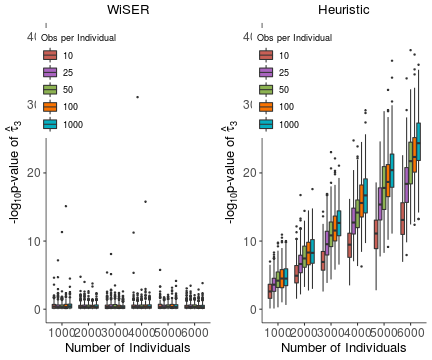

┌ Warning: RCall.jl: Warning: Removed 2 rows containing non-finite values (stat_boxplot).
└ @ RCall /home/cgerman/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


In [7]:
using RCall

df2R = deepcopy(df2)
rename!(df2R, [:t2wiser
        :t2naive
        :t3wiser
        :t3naive
        :t4wiser
        :t4naive
        :t5wiser
        :t5naive
        :samplesize
        :obssize
        :logt2wiser
        :logt3wiser
        :logt4wiser
        :logt5wiser
        :logt2naive
        :logt3naive
        :logt4naive
        :logt5naive])
@rput df2R
R"""
library(ggplot2)
library(gridExtra)
df2R$obssize <- factor(df2R$obssize, levels = c('10', '25', '50', '100', '1000'))
df2R$logt3wiser = unlist(df2R$logt3wiser)

tw3 <- ggplot(df2R, aes(x=samplesize, y=logt3wiser, fill=obssize)) + 
  geom_boxplot(outlier.size=0.5) +
  theme(legend.position=c(0.2,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=12),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 13), 
        axis.title.y = element_text(size = 13), legend.title = element_text(size = 9),
        #axis.ticks = element_blank(),
         panel.grid.major = element_blank(), legend.text=element_text(size=9),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) + 
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
ylim(0, 40) + 
  labs(x = "Number of Individuals", y = expression(paste("-",log[10],"p-value of ", hat(tau)[3])), fill = "Obs per Individual",
title = "WiSER")

tn3 <- ggplot(df2R, aes(x=samplesize, y=logt3naive, fill=obssize)) + 
  geom_boxplot(outlier.size=0.5) +
  theme(legend.position=c(0.2,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=12),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 13), 
        axis.title.y = element_text(size = 13), legend.title = element_text(size = 9),
        #axis.ticks = element_blank(),
         panel.grid.major = element_blank(), legend.text=element_text(size=9),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) + 
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
ylim(0, 40) +
  labs(x = "Number of Individuals", y = expression(paste("-",log[10],"p-value of ", hat(tau)[3])), fill = "Obs per Individual",
title = "Heuristic")

t3sd = grid.arrange(tw3, tn3, nrow=1, ncol=2)

"""

In [ ]:
#R"ggsave('result_files/compare_nullpvals_sd_1000reps.png', t3sd, width = 10, height = 5, units = 'in', dpi = 450)"

WiSER reports similar power for all methods so we combine its power curve at different observations per person into one. 

In [8]:
t5wiserpower_all, t5wisermax_all, t5wisermin_all = combine(groupby(df2, :samplesize), 
    :τ5wiser => (x -> mean(x .< 0.05)) => :power,
    :τ5wiser => (x -> sem(x .< 0.05)) => :se) |> x -> (x.power, x.power + x.se, x.power - x.se);

[t5wiserpower_all t5wisermax_all t5wisermin_all]

6×3 Array{Float64,2}:
 0.981982  0.986193  0.977771
 0.995     0.997232  0.992768
 0.995     0.997232  0.992768
 0.999     1.0       0.998
 0.998     0.999414  0.996586
 0.996     0.997997  0.994003

In [9]:
t5naivepower, t5naivemax, t5naivemin = combine(groupby(df2, [:obssize, :samplesize]), :τ5naive => (x -> mean(x .< 0.05)) => :power,
    :τ5naive => (x -> sem(x .< 0.05)) => :se) |> x -> (x.power, x.power + x.se, x.power - x.se);

[t5naivepower t5naivemax t5naivemin]

30×3 Array{Float64,2}:
 0.286432  0.318561   0.254303
 0.175     0.201935   0.148065
 0.12      0.143036   0.0969641
 0.095     0.115785   0.0742145
 0.08      0.0992315  0.0607685
 0.61      0.644576   0.575424
 0.305     0.337637   0.272363
 0.215     0.244122   0.185878
 0.115     0.137615   0.0923851
 0.065     0.0824758  0.0475242
 0.715     0.747      0.683
 0.445     0.480229   0.409771
 0.32      0.353068   0.286932
 ⋮                    
 0.22      0.249365   0.190635
 0.055     0.0711611  0.0388389
 0.91      0.930287   0.889713
 0.675     0.708202   0.641798
 0.415     0.449928   0.380072
 0.255     0.285897   0.224103
 0.06      0.076835   0.043165
 0.97      0.982093   0.957907
 0.72      0.751829   0.688171
 0.51      0.545437   0.474563
 0.27      0.301471   0.238529
 0.07      0.0880869  0.0519131

In [10]:
t5powerdf = DataFrame(obssize = combine(groupby(df2, [:obssize, :samplesize]), :τ2wiser => x -> mean(x .< 0.05))[!, 1],
samplesize = combine(groupby(df2, [:obssize, :samplesize]), :τ2wiser => x -> mean(x .< 0.05))[!, 2],
    t5naivepower = t5naivepower, t5naivemax = t5naivemax, t5naivemin = t5naivemin)
df_w2 = DataFrame(t5wiserpower = t5wiserpower_all, t5wisermax = t5wisermax_all, t5wisermin = t5wisermin_all,
samplesize = string.(collect(1000:1000:6000)))
t5powerdf = leftjoin(t5powerdf, df_w2, on = :samplesize)

,obssize,samplesize,t5naivepower,t5naivemax,t5naivemin,t5wiserpower,t5wisermax,t5wisermin
,String,String,Float64,Float64,Float64,Float64?,Float64?,Float64?
1,10,1000,0.286432,0.318561,0.254303,0.981982,0.986193,0.977771
2,25,1000,0.175,0.201935,0.148065,0.981982,0.986193,0.977771
3,50,1000,0.12,0.143036,0.0969641,0.981982,0.986193,0.977771
4,100,1000,0.095,0.115785,0.0742145,0.981982,0.986193,0.977771
5,1000,1000,0.08,0.0992315,0.0607685,0.981982,0.986193,0.977771
6,10,2000,0.61,0.644576,0.575424,0.995,0.997232,0.992768
7,25,2000,0.305,0.337637,0.272363,0.995,0.997232,0.992768
8,50,2000,0.215,0.244122,0.185878,0.995,0.997232,0.992768
9,100,2000,0.115,0.137615,0.0923851,0.995,0.997232,0.992768


##### Figure 5

This recreates figure 5.

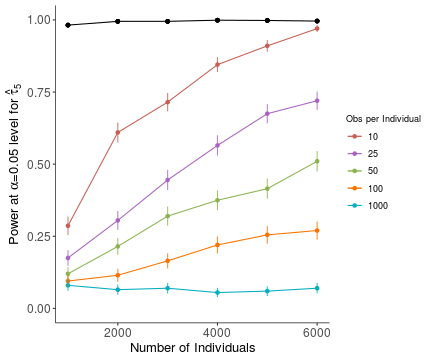

RObject{VecSxp}


In [11]:
using RCall

@rput t5powerdf
R"""
library(ggplot2)
library(gridExtra)
t5powerdf$obssize <- factor(t5powerdf$obssize, levels = c('10', '25', '50', '100', '1000'))
t5powerdf$samplesize <- as.numeric(as.character(t5powerdf$samplesize))#factor(df2R$obssize, levels = c('10', '25', '50', '100', '1000'))

#df2R$logt3wiser = unlist(df2R$logtwiser)

t5 <- ggplot(t5powerdf, aes(x=samplesize, y=t5naivepower, color = obssize)) + 
    geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=t5naivemin, ymax=t5naivemax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=12),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 13), 
        axis.title.y = element_text(size = 13), legend.title = element_text(size = 9),
        #axis.ticks = element_blank(),
         panel.grid.major = element_blank(), legend.text=element_text(size=9),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) + 
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
ylim(0, 1) +
  labs(x = "Number of Individuals", y = expression(paste("Power at ", alpha, "=0.05 level for ", hat(tau)[5])),
color = "Obs per Individual")#,
#title = "Power Comparison between naive (color) and WiSER (black)")
 
t5 = t5 +  geom_line(aes(x=samplesize, y=t5wiserpower), color="black") +
  geom_point(aes(x=samplesize, y=t5wiserpower), color="black")+
  geom_errorbar(aes(ymin=t5wisermin, ymax=t5wisermax), width=0.5, alpha = 0.8, position=position_dodge(0.005), color="black")
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x))
#ylim(0, 1) 
#  labs(x = "Number of Individuals", y = expression(paste("Power at ", alpha, "=0.05 level for ", hat(tau)[5])), fill = "Obs per Individual",
#title = "WiSER")

"""

In [ ]:
#R"ggsave('result_files/timevarpowercomp_1000reps.png', t5, width = 6, height = 5, units = 'in', dpi = 450)"